In [1]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
load_data = False

In [500]:
print(f'Lx is {10/2.5}')
print(f'Ly is {1/10}')

Lx is 4.0
Ly is 0.1


In [593]:
N_Z = 960
K = 32
I = 12

# F = float(15) # error grows non-linearly
# b = float(10)
# c = float(2.5)

# this_Lx = float(10/2.5) # same as above
# F = float(15)
# b = float(10)
# c = float(b/this_Lx)

# this_Lx = 2
# F = float(15)
# b = float(8)
# c = float(b/this_Lx)

this_Lx = 2
F = float(15/(this_Lx/4))
b = float(8)
c = float(b/this_Lx)

# F = float(15) # error still grows linearly
# b = float(9.5)
# c = float(2.5)

alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)

coarse = 8
N_Xc = N_Z//coarse
K_c = K//coarse

N_eZ = 100

save_dir = 'LM3_error_growth2'
home = os.path.expanduser('~')
save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)


dt_rk = 0.005/24
dt_obs = 0.005/24

# T_ic = (120)/5
T_ic = 50
T_gt = 1

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
this_path = os.path.join(save_dir, 't_gt.npy')
if load_data:
    t_gt = np.load(this_path)
else:
    t_gt = np.linspace(0, T_gt, int(T_gt/dt_obs) + 1)
    np.save(this_path, t_gt)

In [594]:
# N_Z = 960
# K = 32
# I = 12
# F = float(15)
# b = float(10)
# # b = float(7)
# c = float(2.5)
# alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
# beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)

# coarse = 8
# N_Xc = N_Z//coarse
# K_c = K//coarse

# N_eZ = 100
# save_dir = 'LM3_error_growth'
# home = os.path.expanduser('~')
# save_dir = os.path.join(
#     home,
#     'Documents/python_code/multi_loc/notebooks/',
#     save_dir)


# dt_rk = 0.05/12

# T_ic = (120)/5

# T_cycle = 8
# N_cycle = 100

# T_gt = T_cycle*N_cycle

# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)
# this_path = os.path.join(save_dir, 't_gt.npy')
# if load_data:
#     t_gt = np.load(this_path)
# else:
#     t_gt = np.linspace(0, T_gt, int(T_gt/dt_rk) + 1)
#     np.save(this_path, t_gt)

In [595]:
this_path = os.path.join(save_dir, 'Z_GT.npy')
if load_data:
    Z_GT = np.load(this_path)
else:
    X_interp = np.random.uniform(low=-5, high=10, size=N_Z//K)
    X_interp = np.concatenate([X_interp, [X_interp[0]]])
    x = np.arange(N_Z)
    x_interp = x[::K]
    x_interp = np.concatenate([x_interp, [x[-1] + 1]])
    f_X = interpolate.interp1d(x_interp, X_interp, kind='quadratic')
    X0 = f_X(x)
    
#     Y0 = np.random.uniform(low=-0.5, high=1, size=N_Z)
    Y0 = np.random.uniform(low=-4, high=4, size=N_Z)

    Z0 = X0 + X0*Y0/X0.max()
    this_dt_rk = 0.05/24
    this_dt_obs = 0.05/24
    Z = utilities.return_LM3_data(Z0, this_dt_rk, T_ic, this_dt_obs, K=K, I=I, F=F, b=b, c=c)
    Z0 = Z[:, -1]
    Z_GT = utilities.return_LM3_data(
        Z0, dt_rk, T_gt, dt_obs, K=K, I=I, F=F, b=b, c=c)
    np.save(this_path, Z_GT)

In [596]:
X_GT = utilities.window_sum_Z(Z_GT, I=I, alpha=alpha, beta=beta)
Y_GT = Z_GT - X_GT

F is 30.0
b is 8.0
c is 4.0
Lx is 0.125
Ly is 2.0
Z std is 4.32481462577251
X std is 4.2320316054237885
Y std is 0.8349713400515343
abs(Z) mean is 4.796914681990276
abs(X) mean is 4.7609265537366445
abs(Y) mean is 0.5567849171600342


Text(0.5, 1.0, 'Time series of Z')

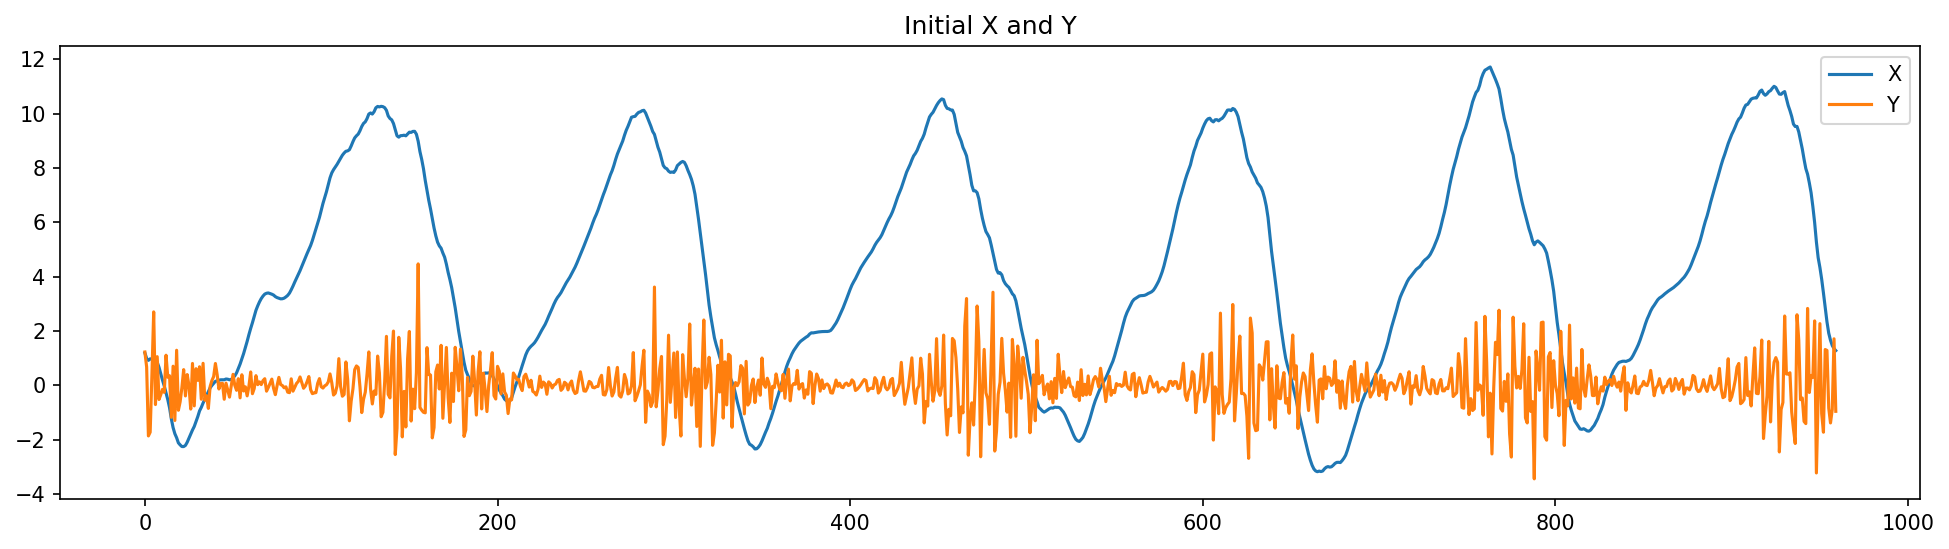

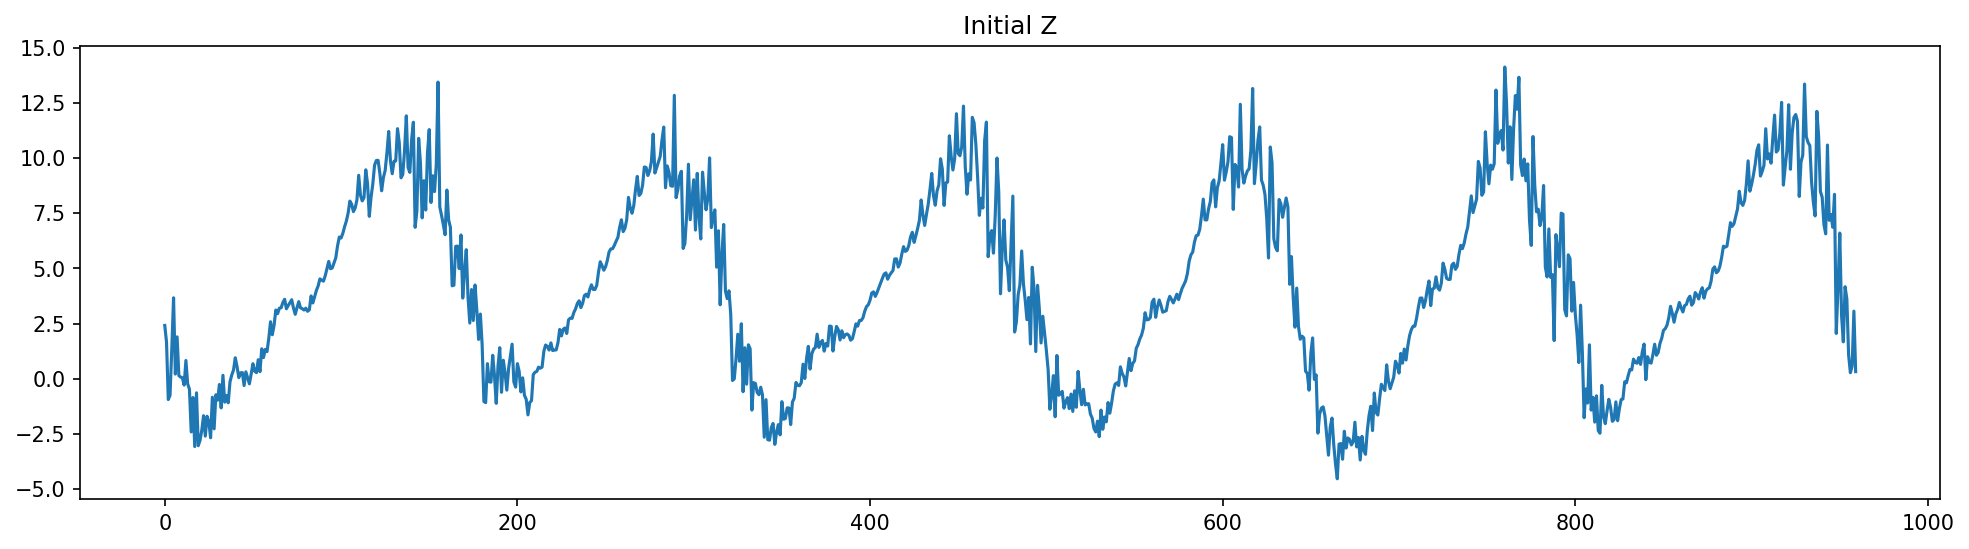

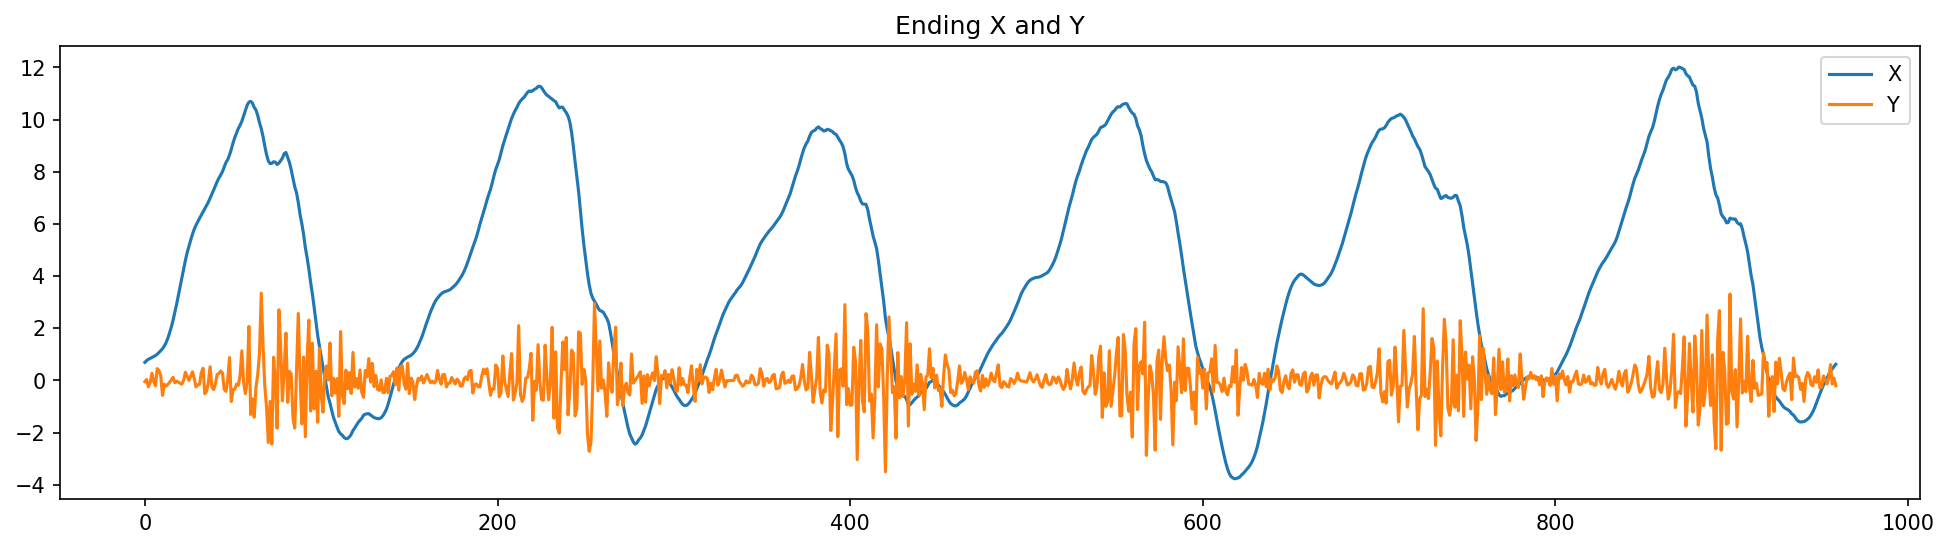

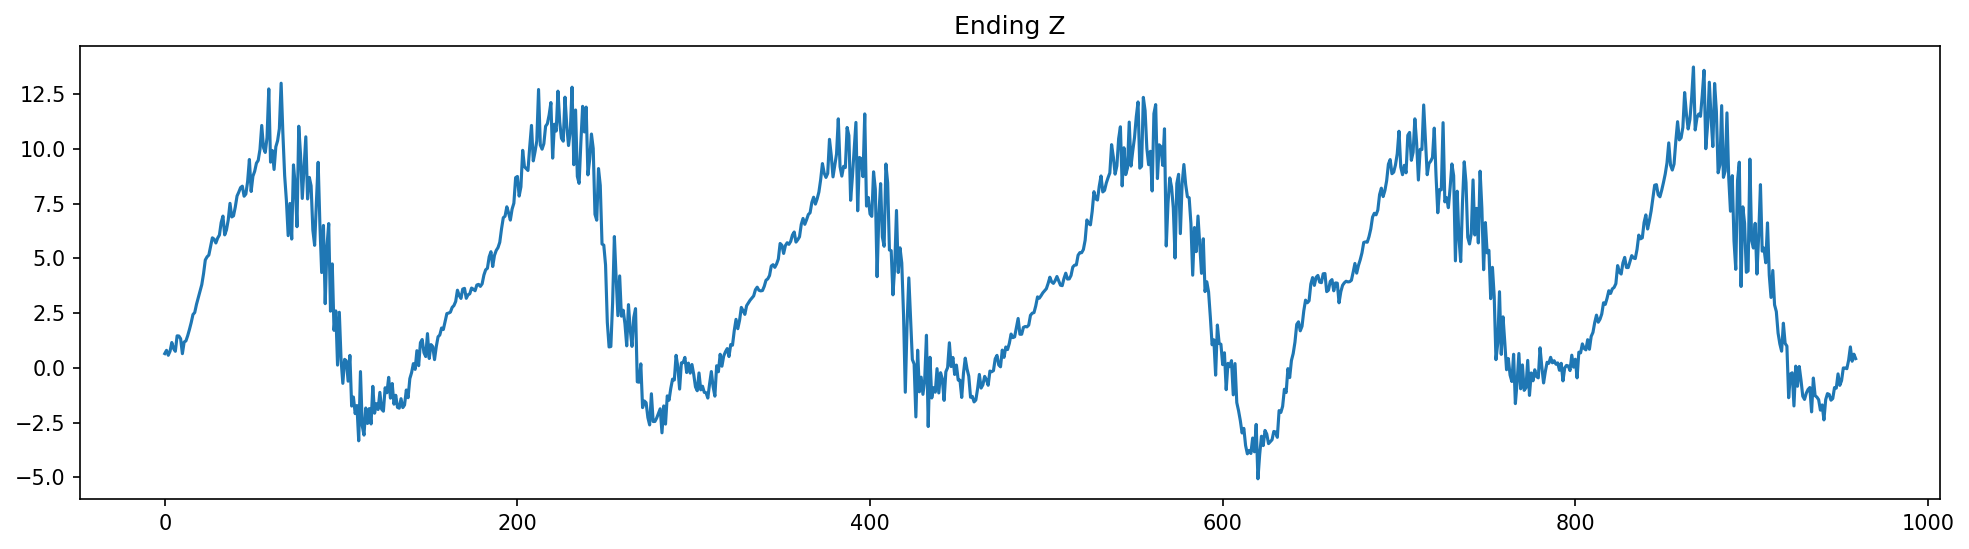

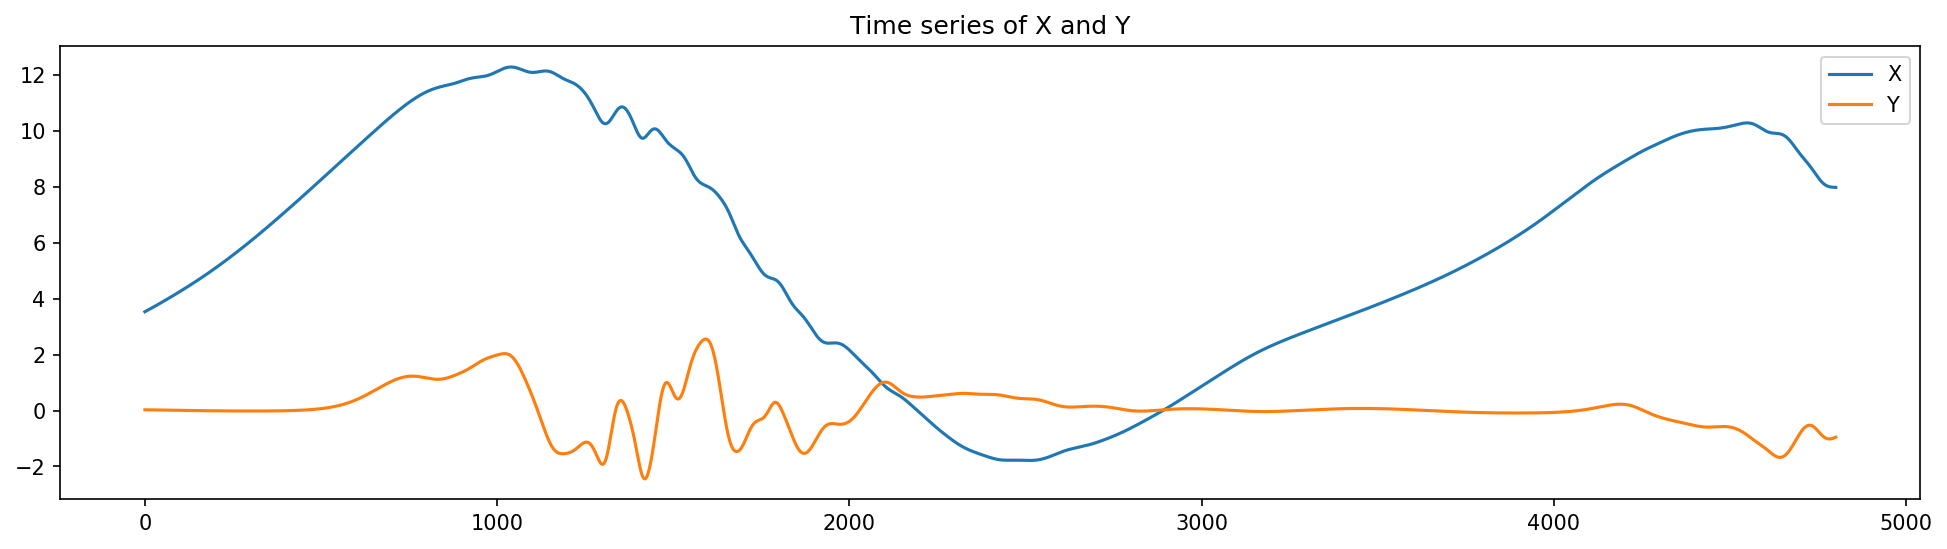

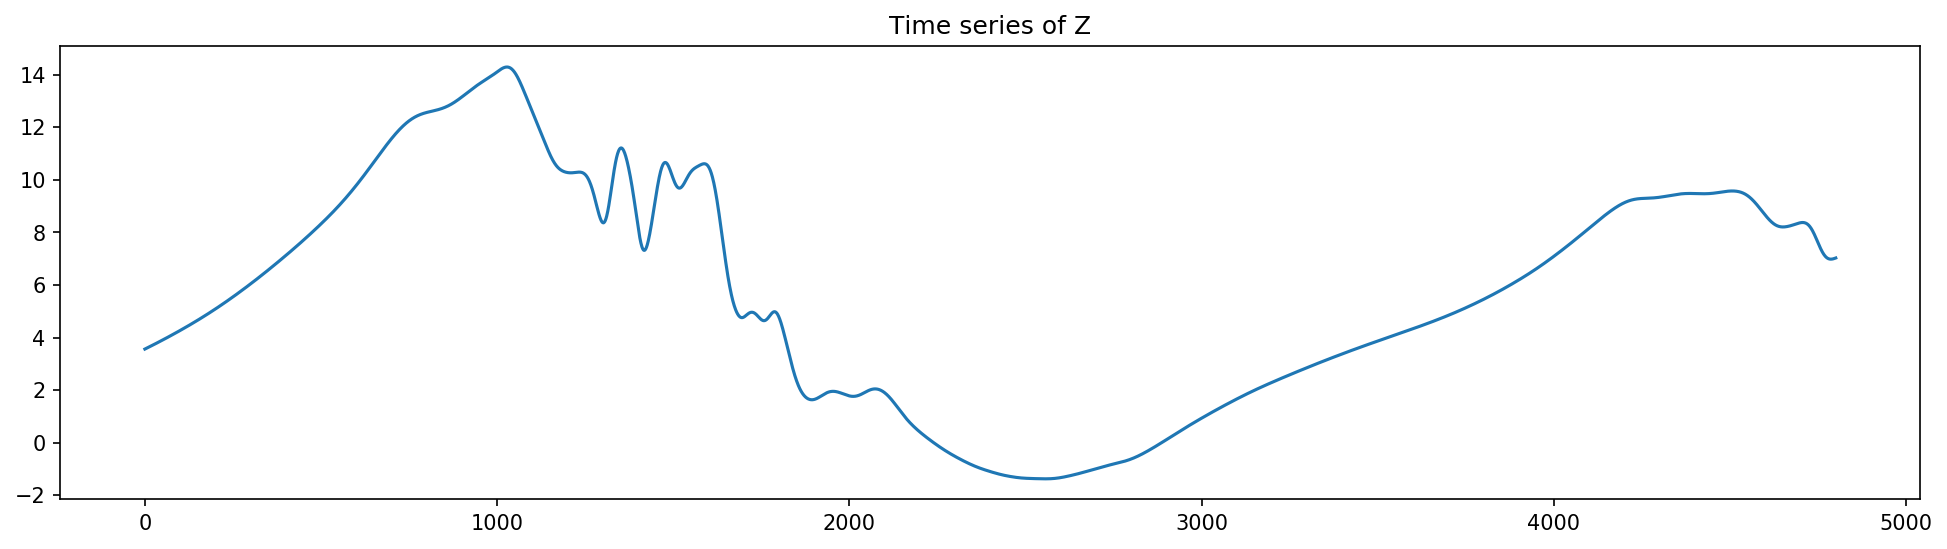

In [598]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

a_ii = 400

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[a_ii])
plt.plot(Y_GT[a_ii])
plt.legend(['X', 'Y'])
plt.title('Time series of X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[a_ii])
plt.title('Time series of Z')

F is 30.0
b is 8.0
c is 4.0
Lx is 0.125
Ly is 2.0
Z std is 4.297787944482037
X std is 4.206391175844933
Y std is 0.827851903232326
abs(Z) mean is 4.716256413806536
abs(X) mean is 4.680299430551627
abs(Y) mean is 0.5511346133635958


Text(0.5, 1.0, 'Time series of Z')

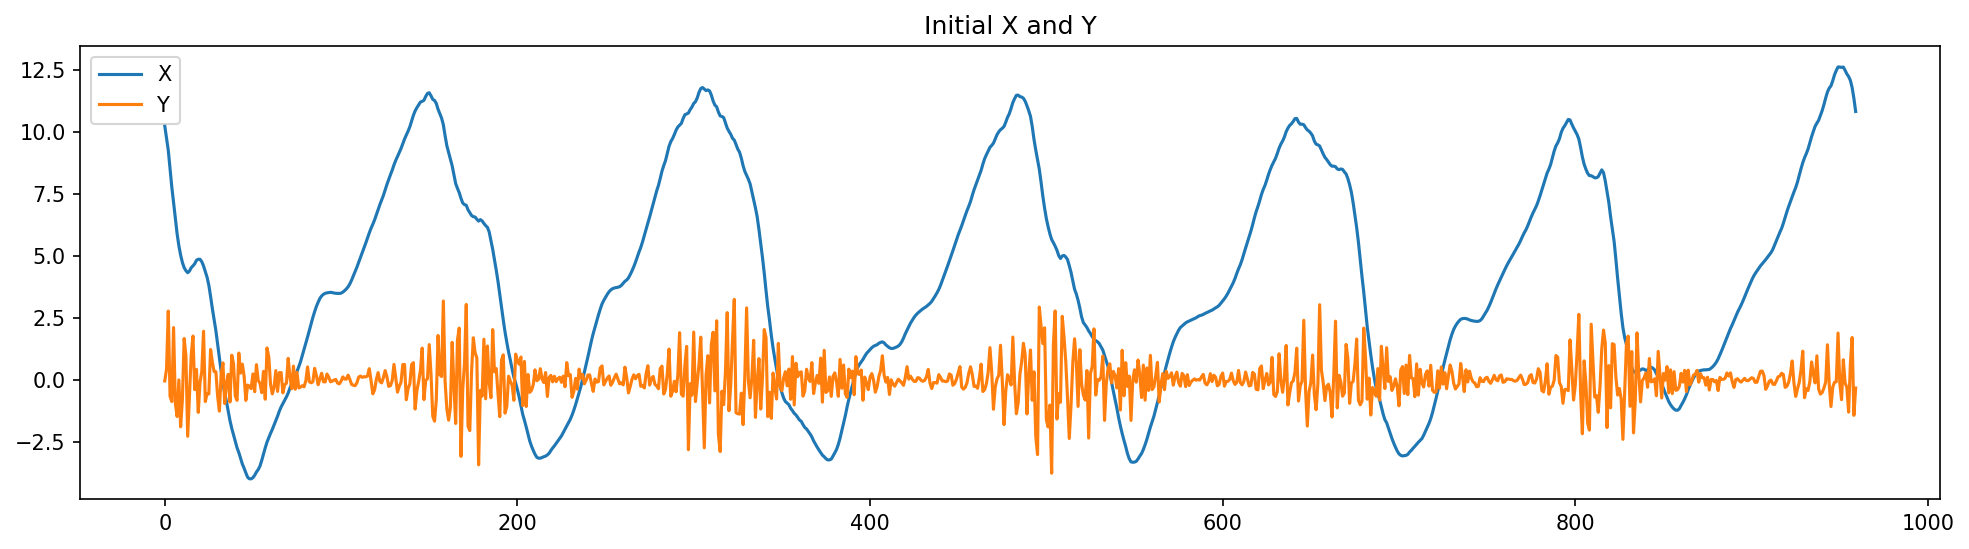

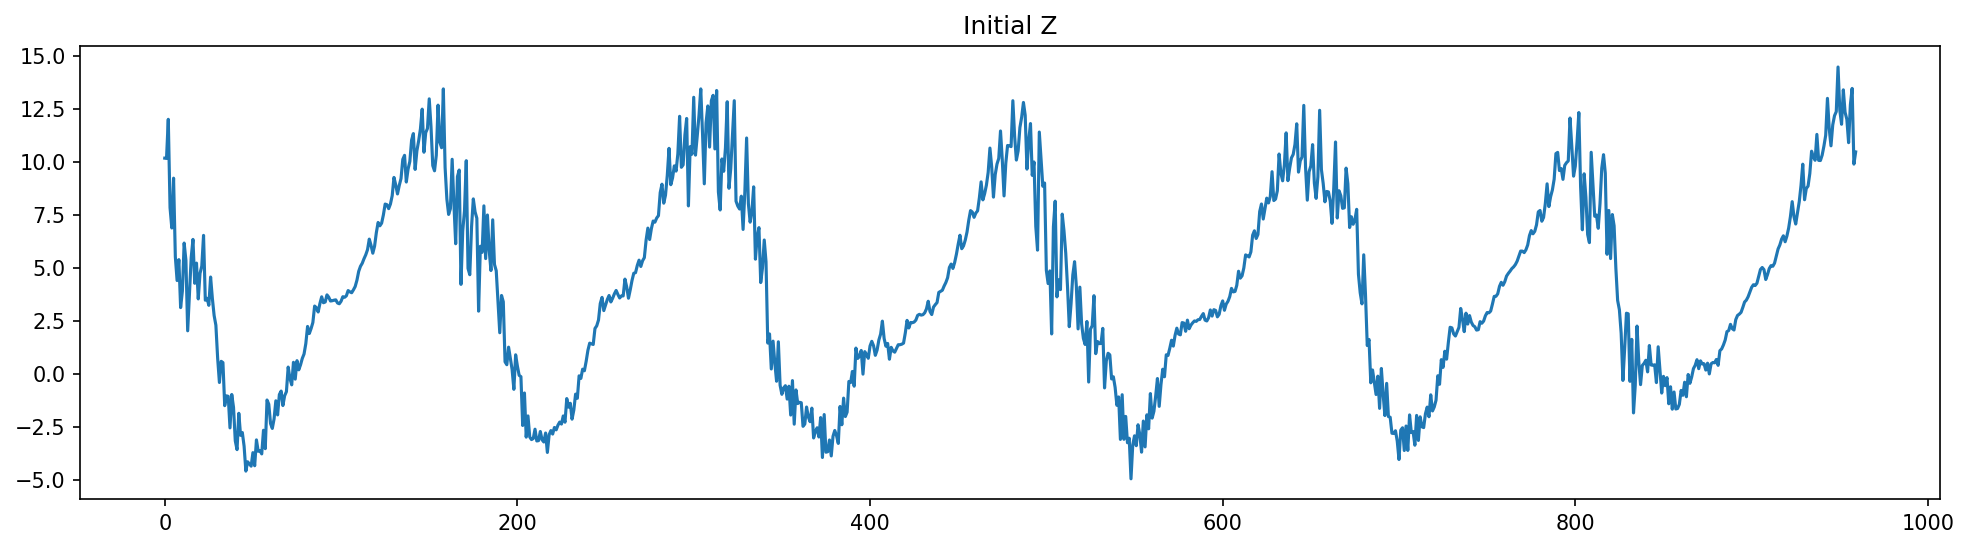

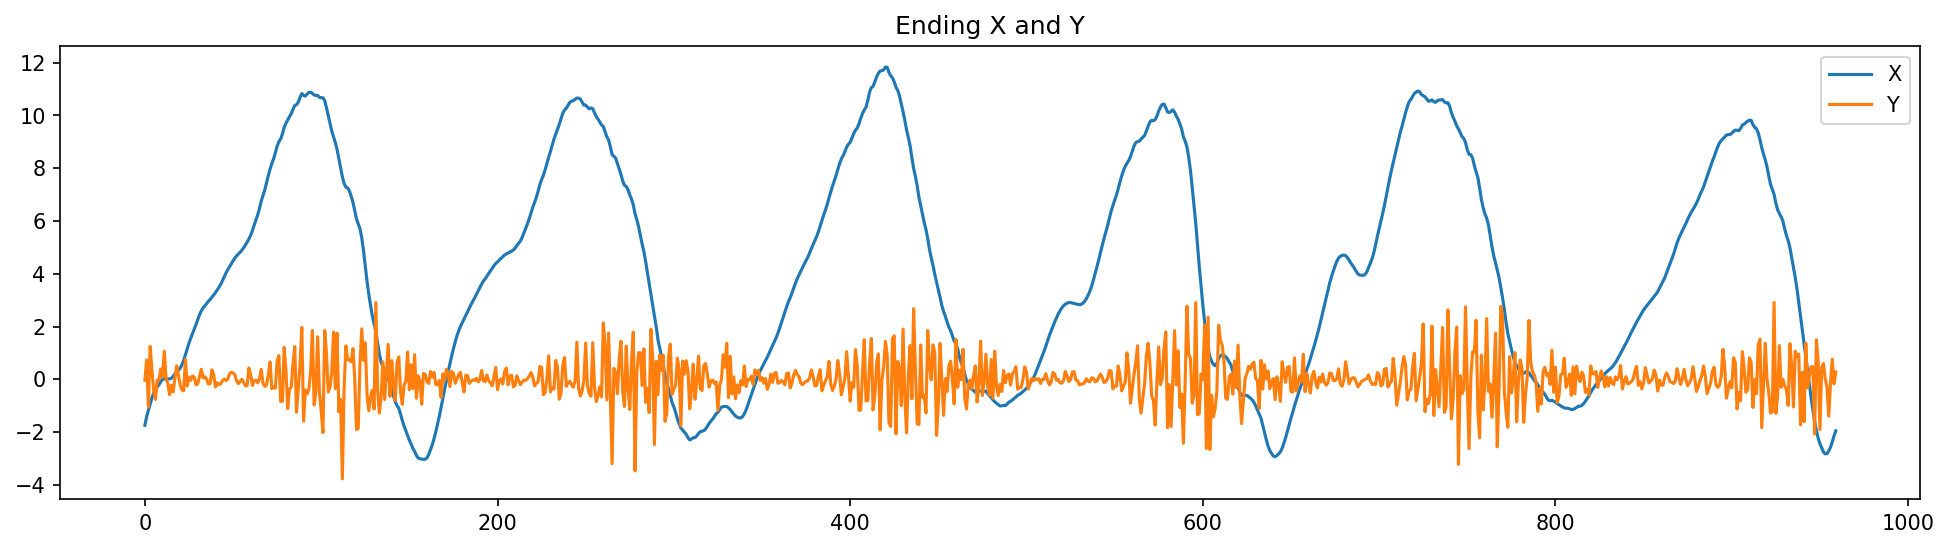

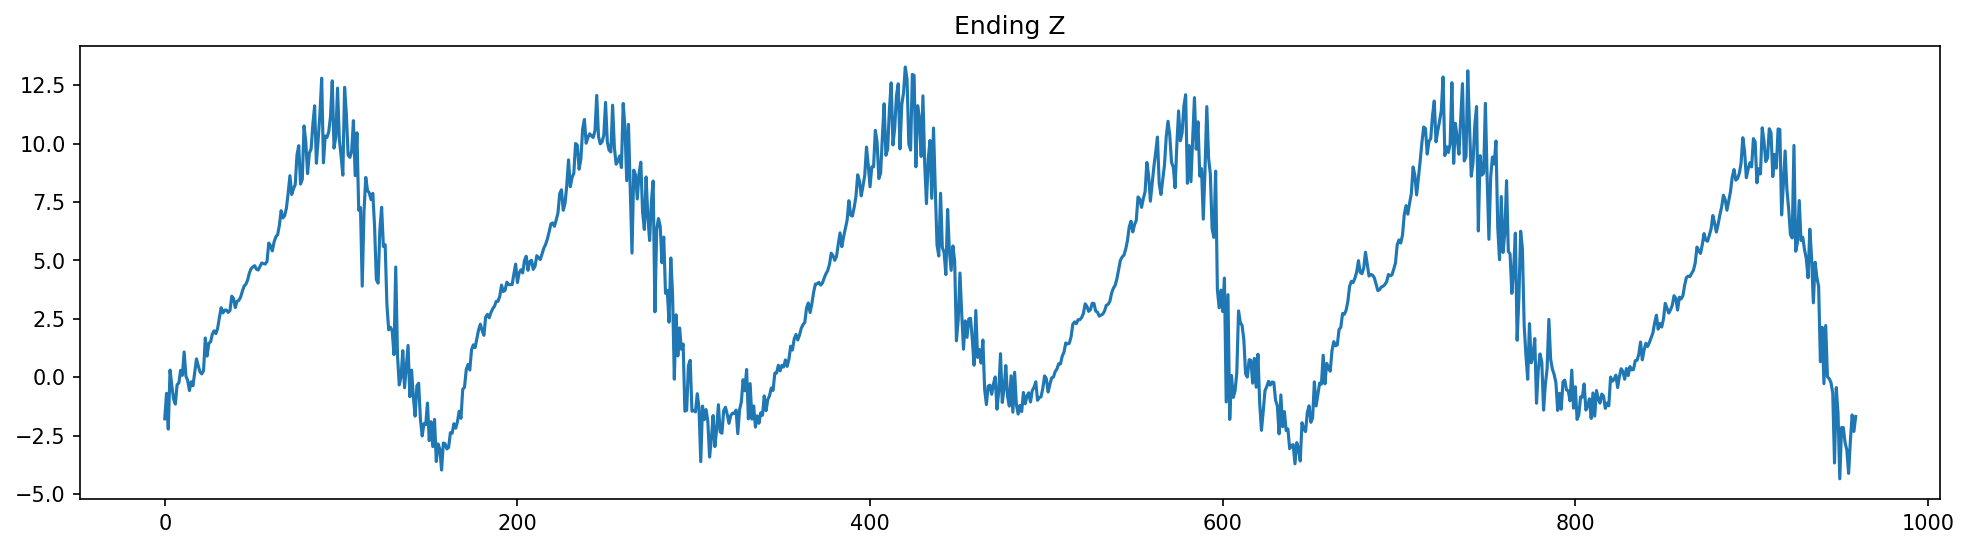

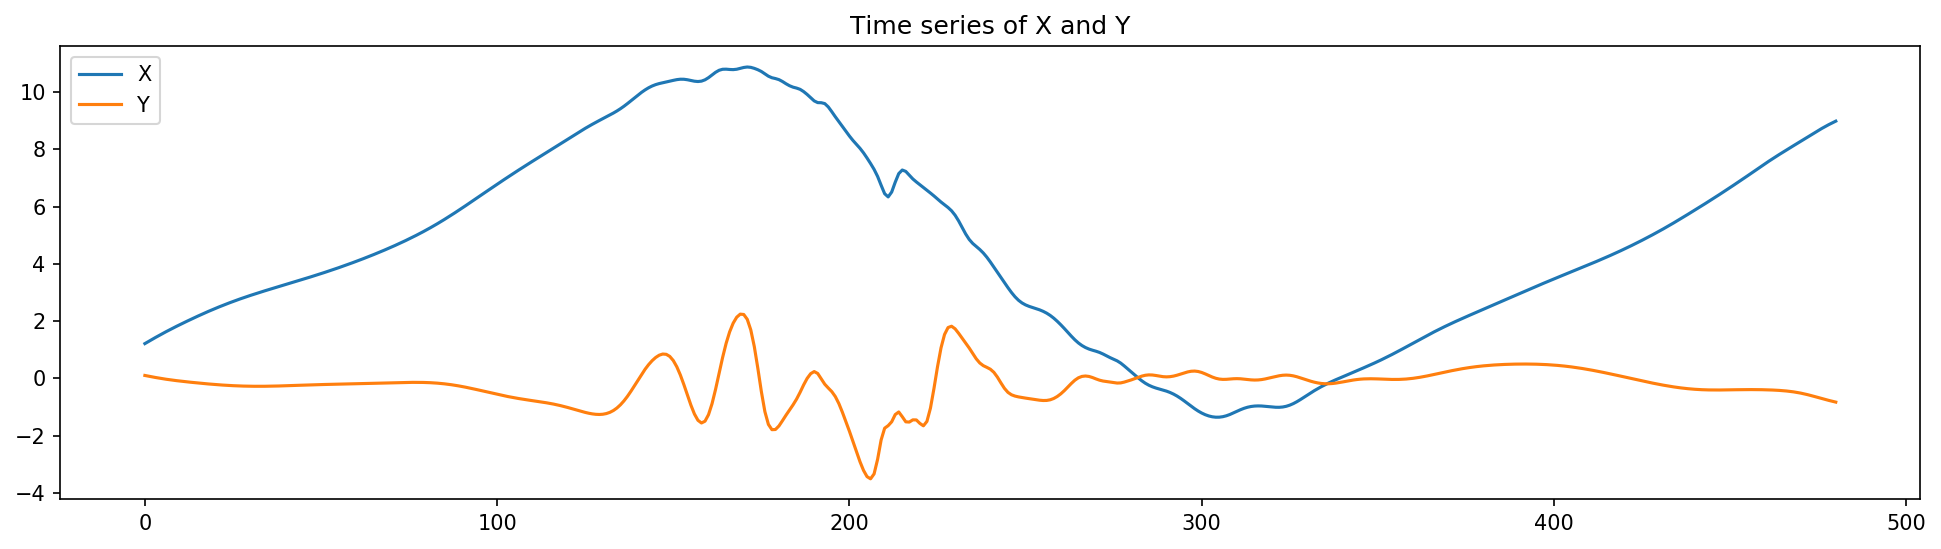

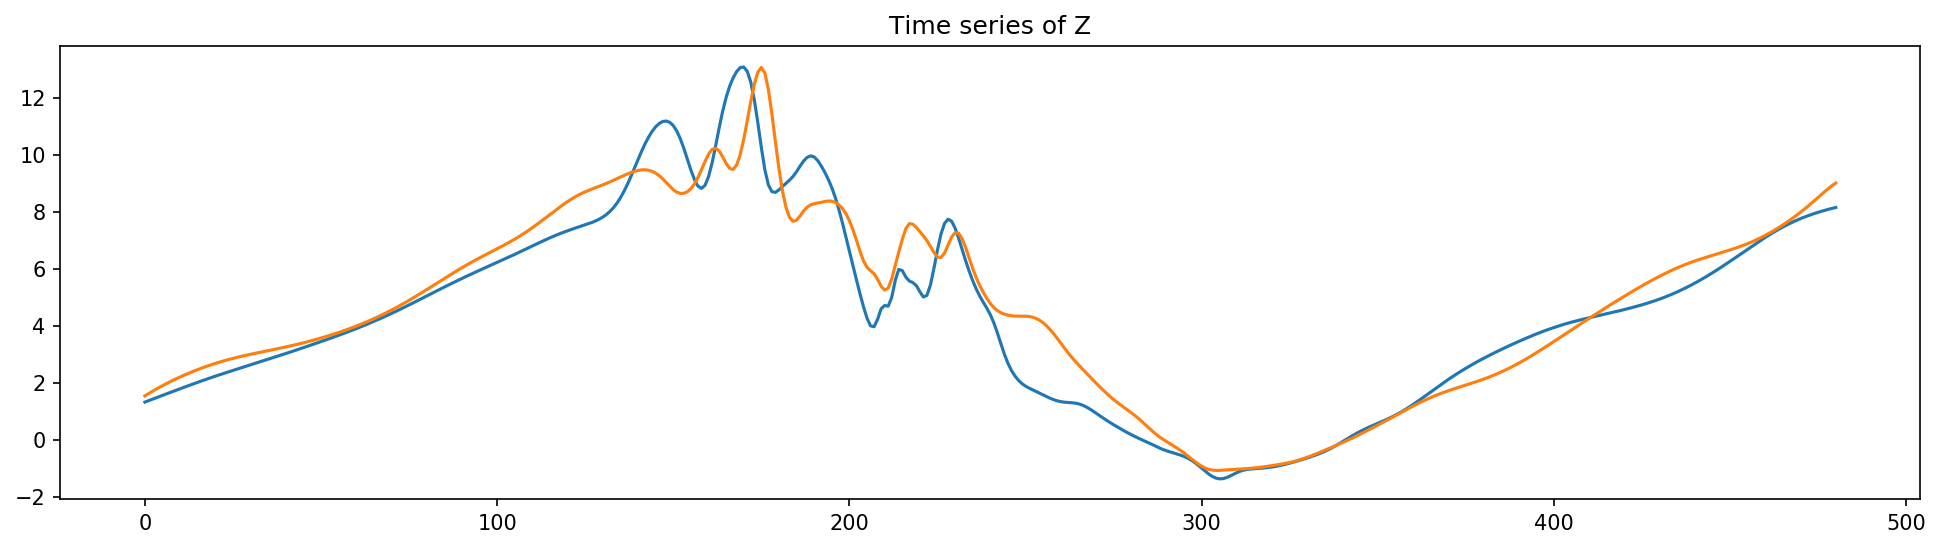

In [592]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

a_ii = 400

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[a_ii])
plt.plot(Y_GT[a_ii])
plt.legend(['X', 'Y'])
plt.title('Time series of X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[a_ii])
plt.title('Time series of Z')

F is 15.0
b is 8.0
c is 2.6666666666666665
Lx is 0.125
Ly is 3.0
Z std is 4.2420779812628515
X std is 4.226018912249131
Y std is 0.30016326376180685
abs(Z) mean is 4.283122925189974
abs(X) mean is 4.2778737340918935
abs(Y) mean is 0.18582749954760713


Text(0.5, 1.0, 'Ending Z')

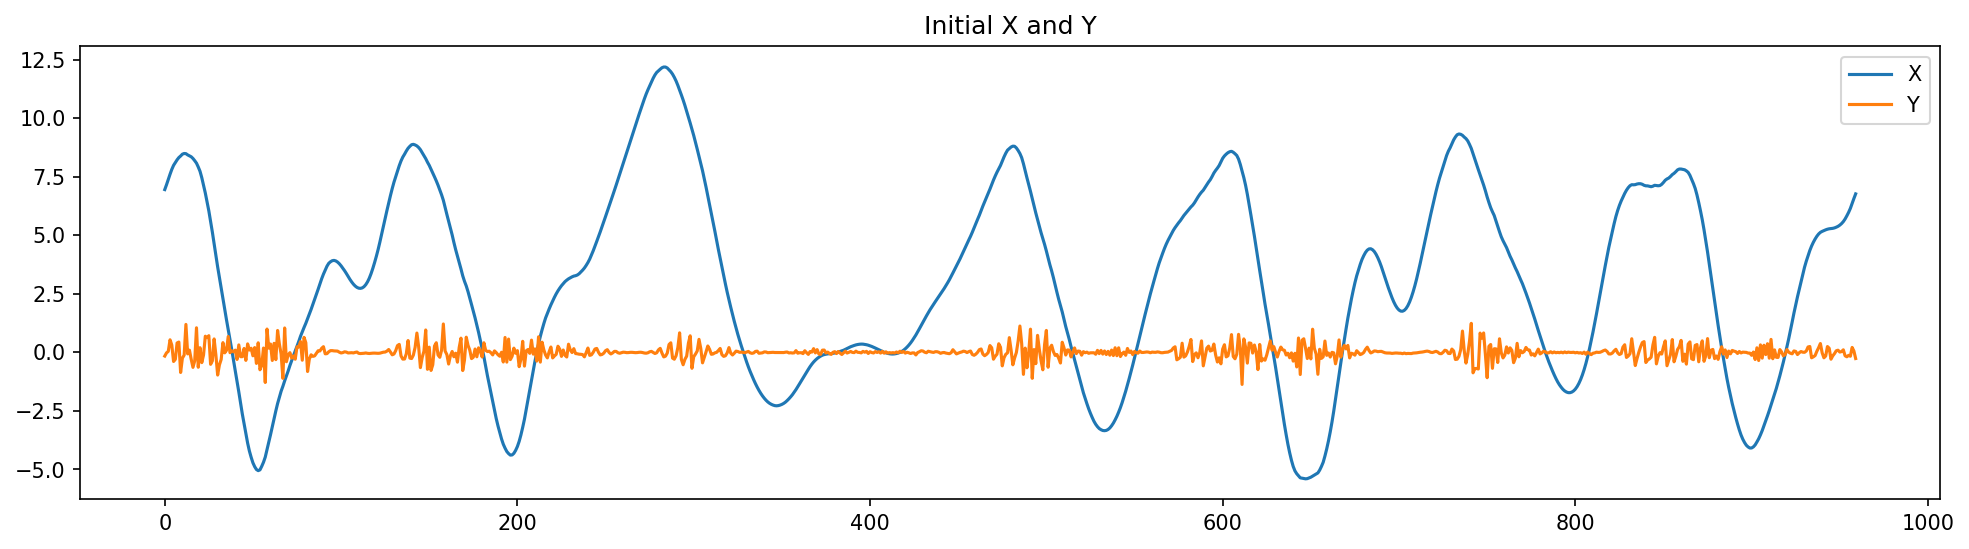

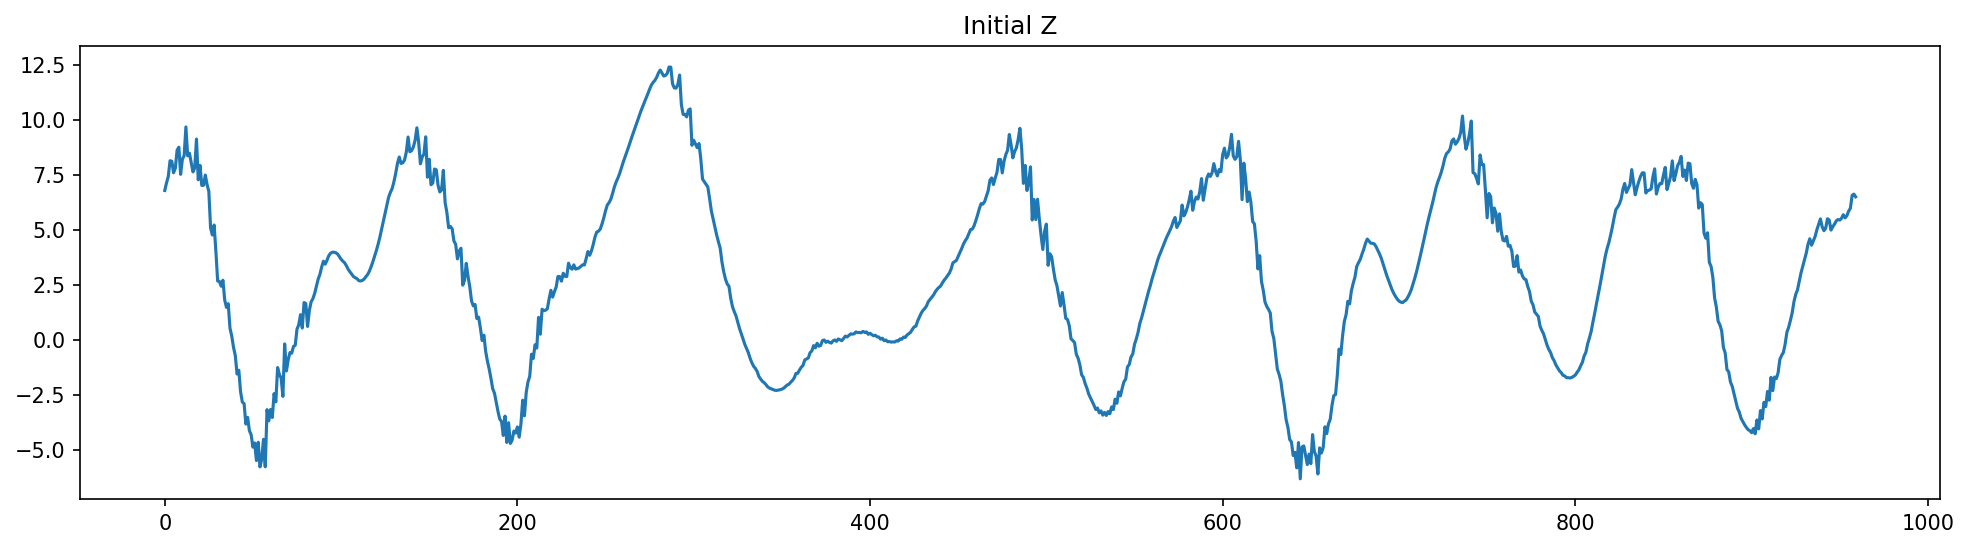

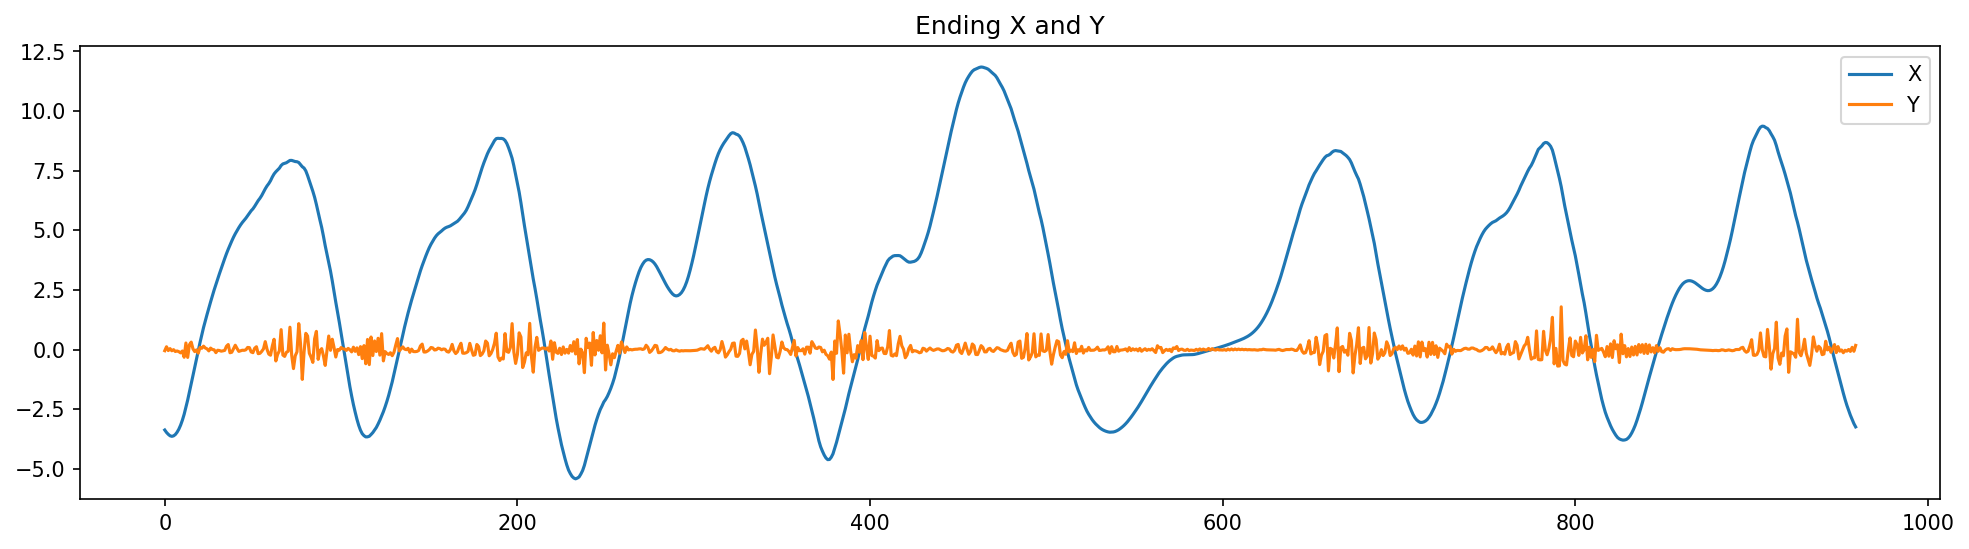

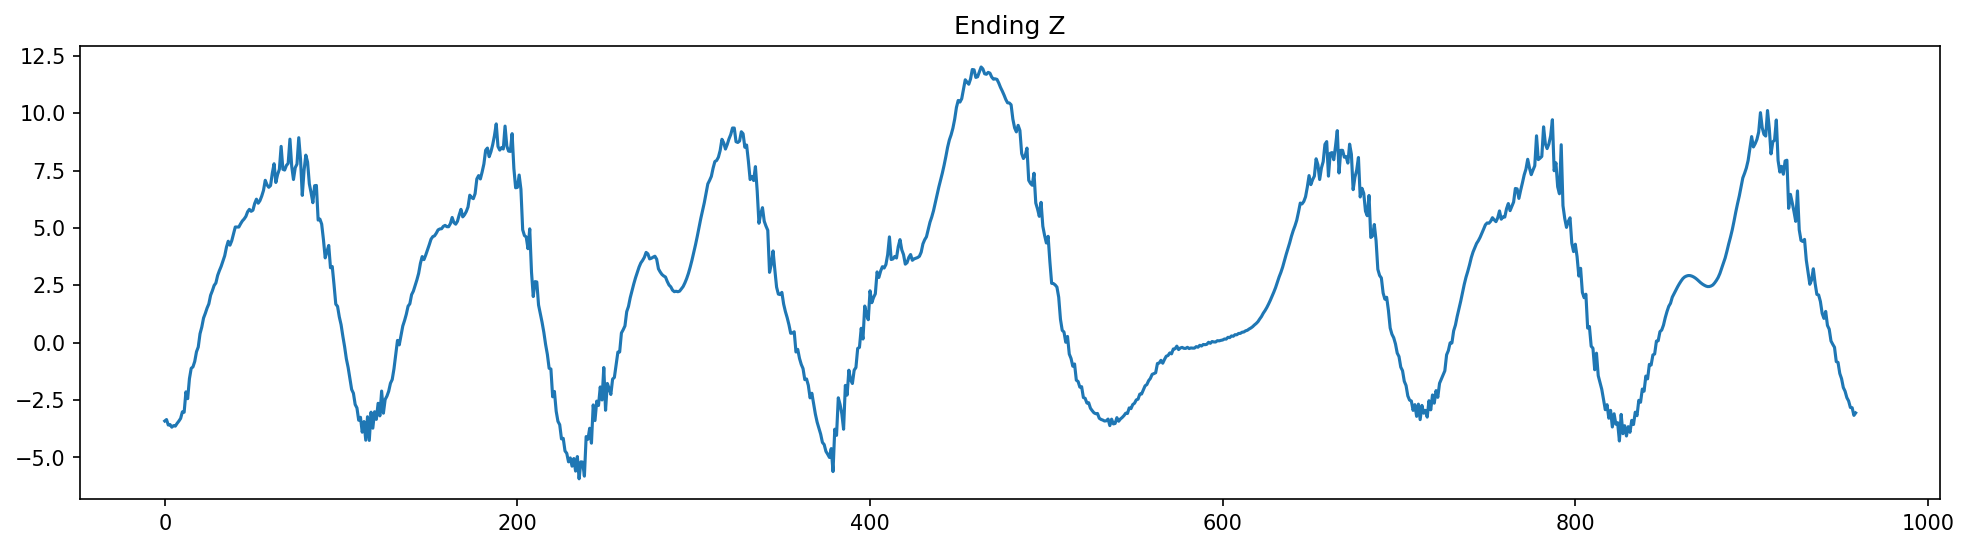

In [537]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

F is 15.0
b is 9.0
c is 3.0
Lx is 0.1111111111111111
Ly is 3.0
Z std is 4.21651999870216
X std is 4.203429603803191
Y std is 0.2598545742209024
abs(Z) mean is 4.2765183371162925
abs(X) mean is 4.272625874793615
abs(Y) mean is 0.1621840862045152


Text(0.5, 1.0, 'Ending Z')

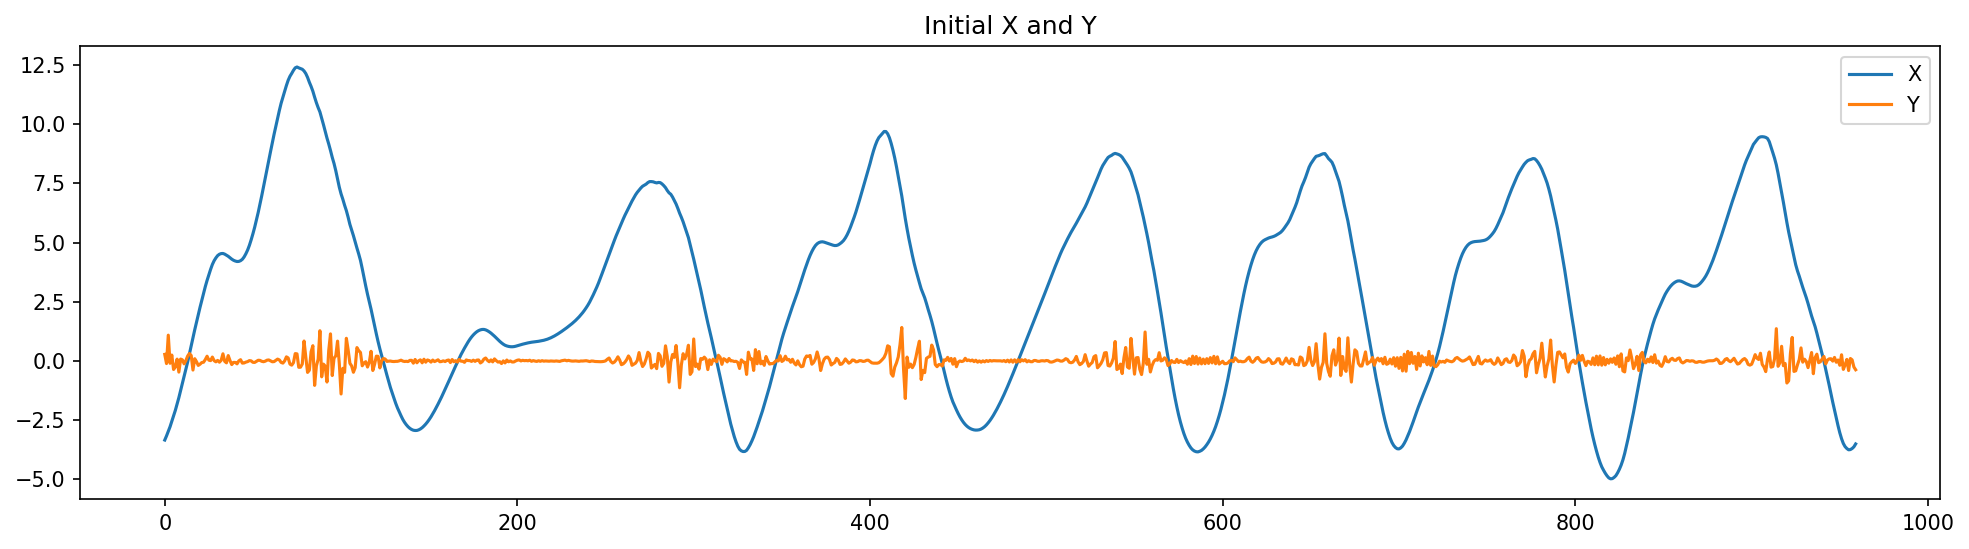

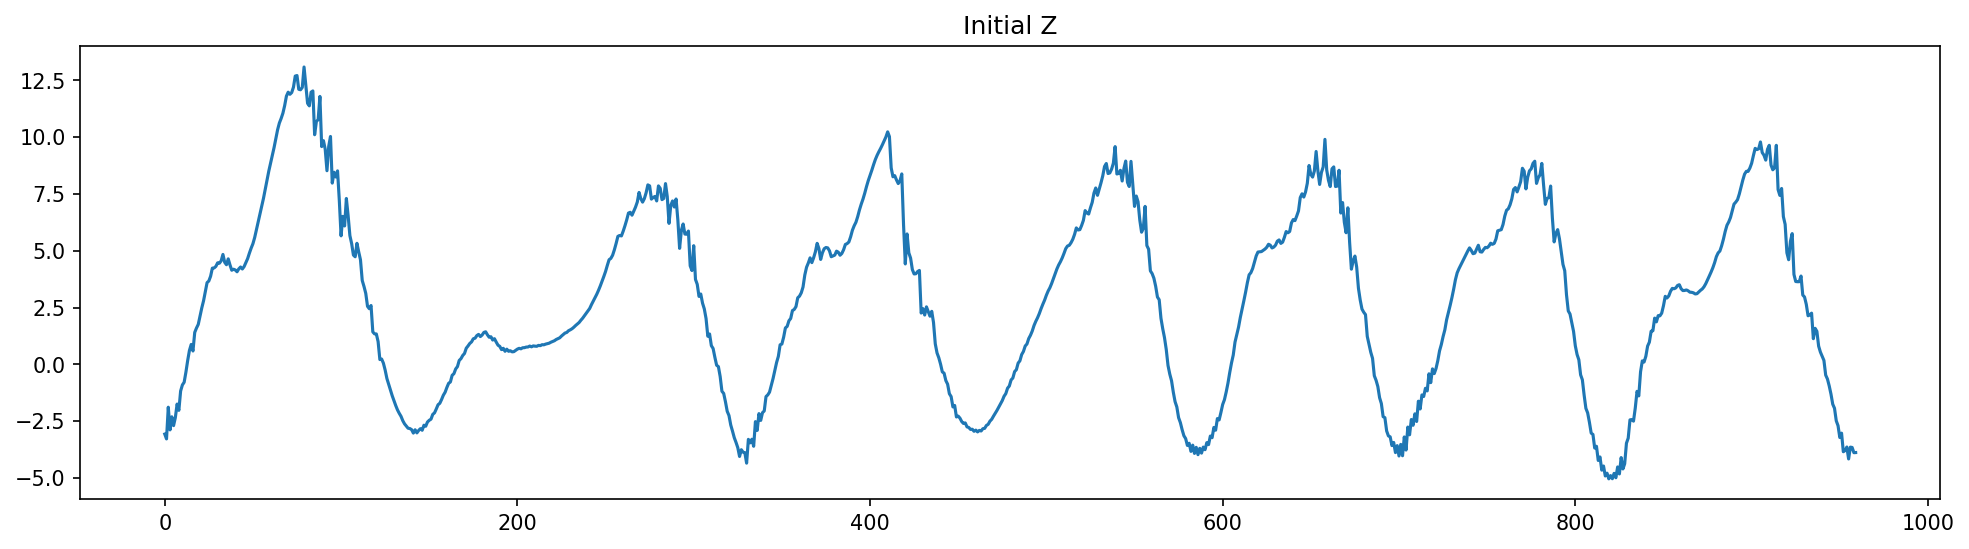

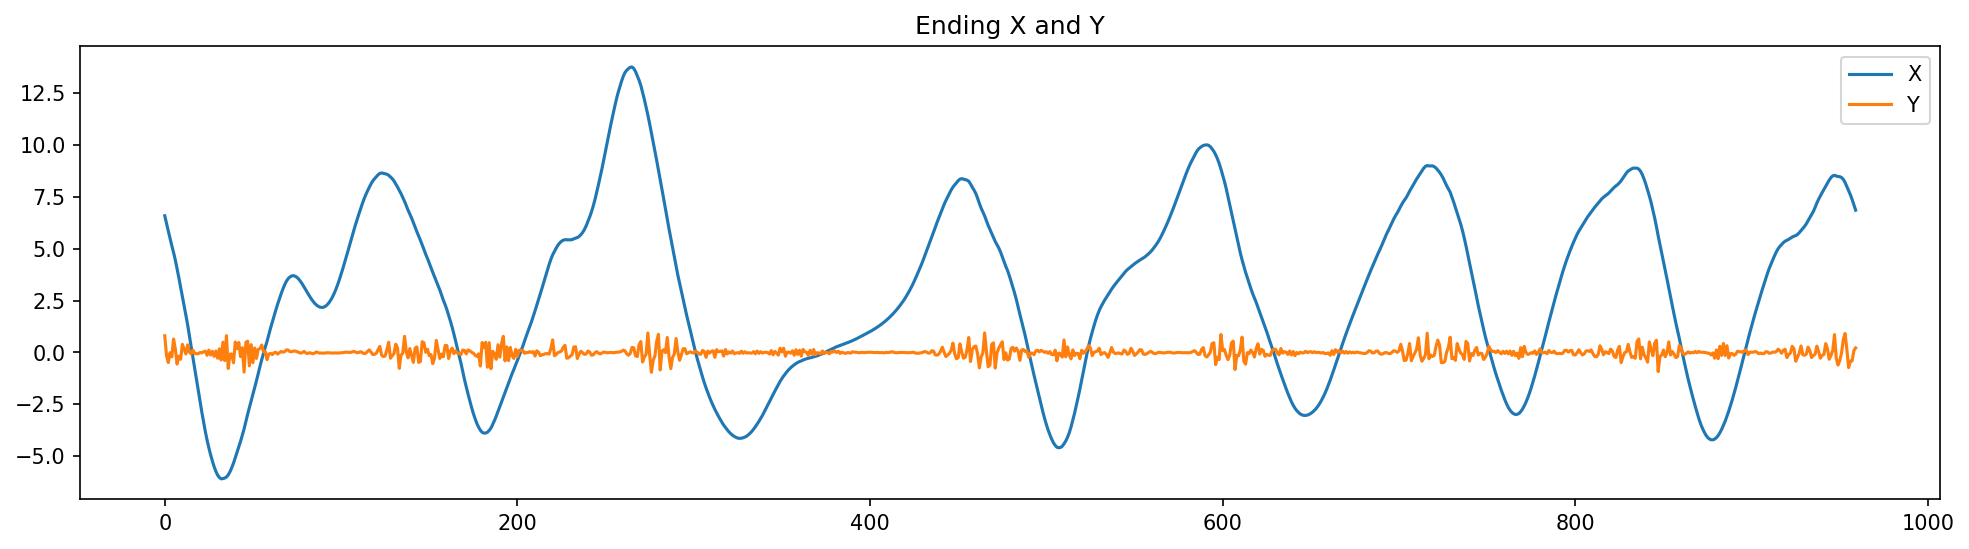

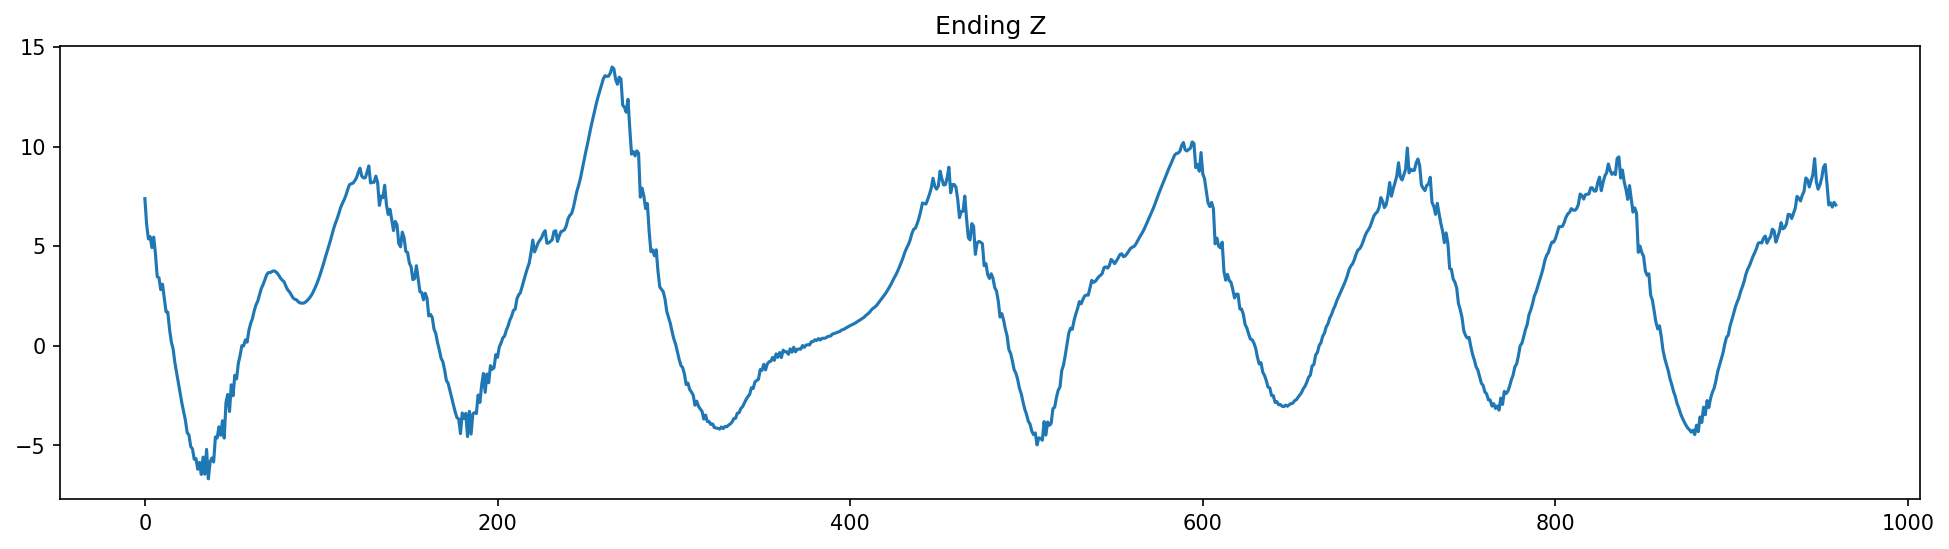

In [532]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

F is 15.0
b is 10.0
c is 3.3333333333333335
Lx is 0.1
Ly is 3.0
Z std is 4.145420976201672
X std is 4.133909044457846
Y std is 0.2424855574865683
abs(Z) mean is 4.193114363616779
abs(X) mean is 4.18962650125042
abs(Y) mean is 0.14918823018236796


Text(0.5, 1.0, 'Ending Z')

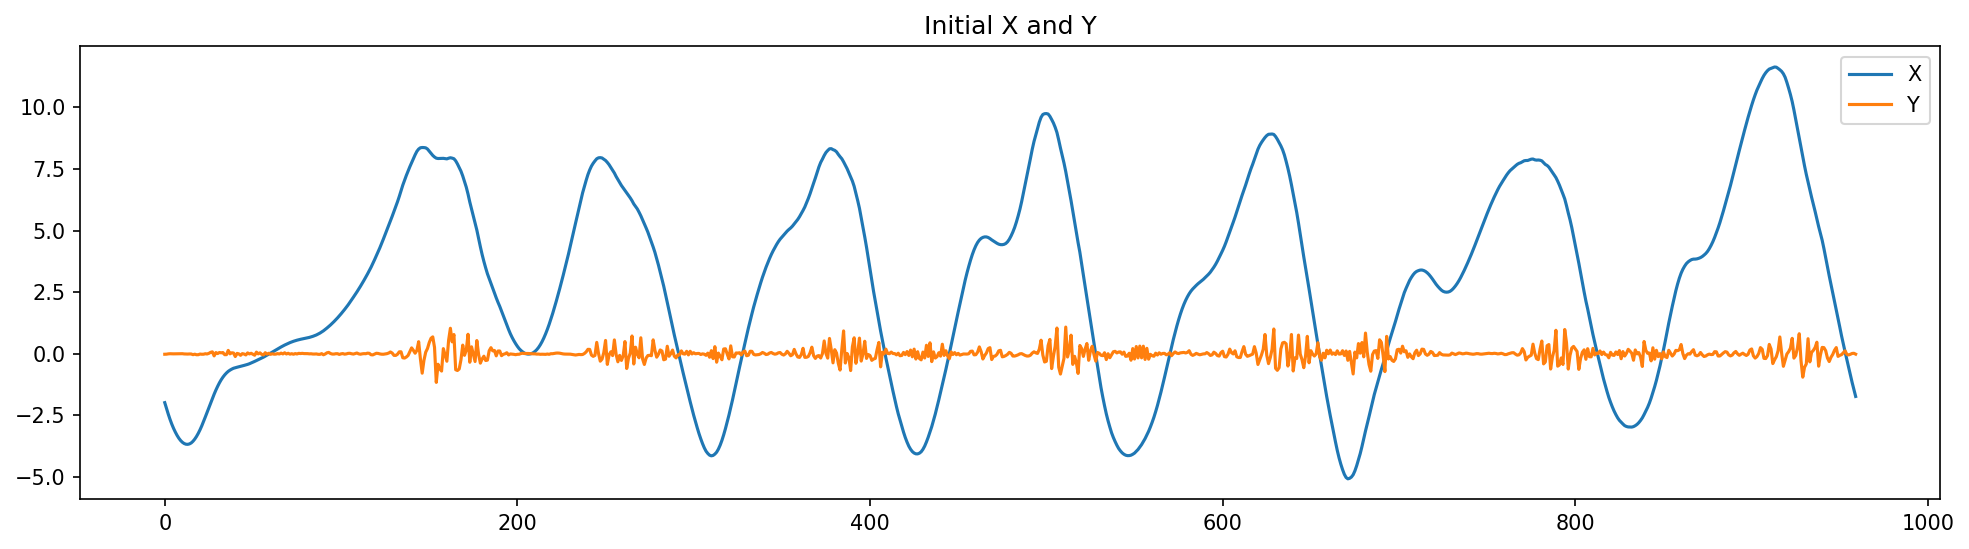

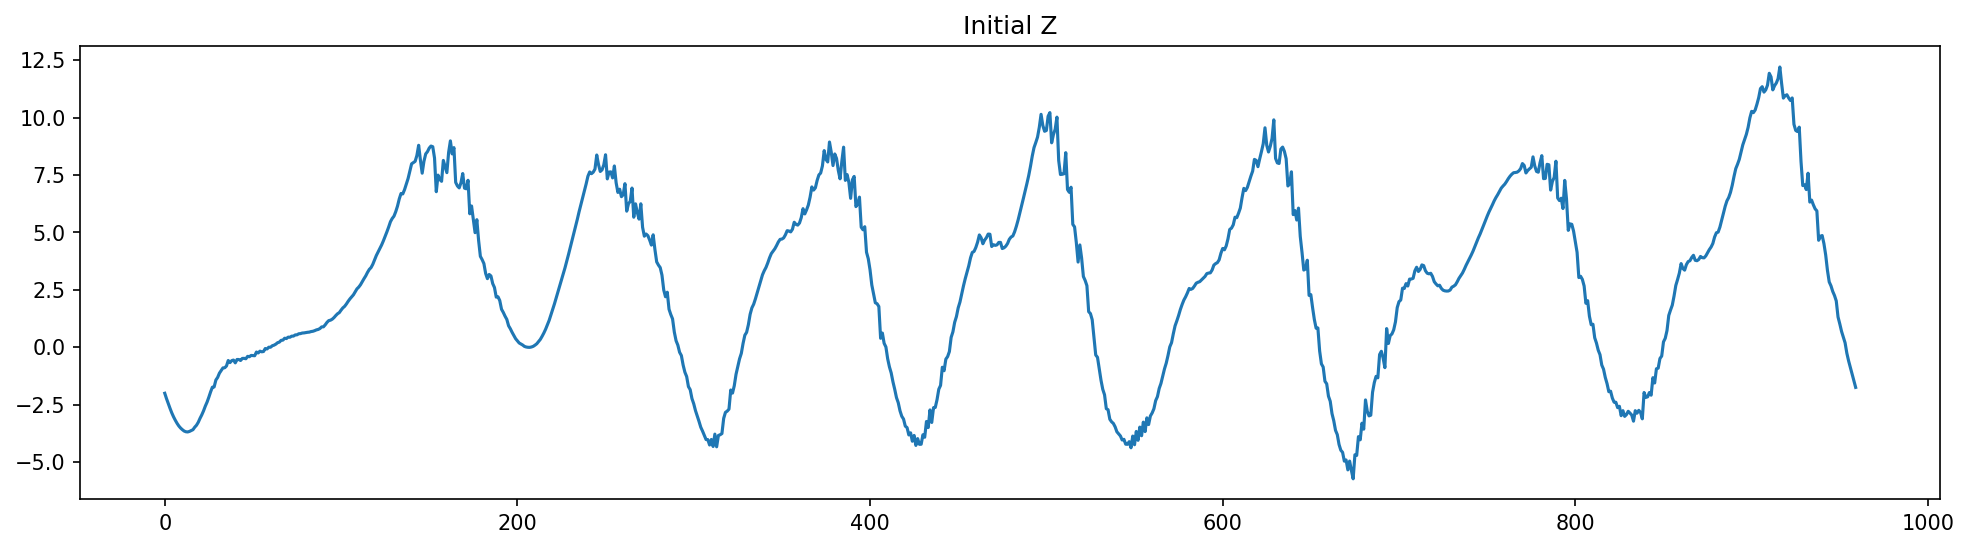

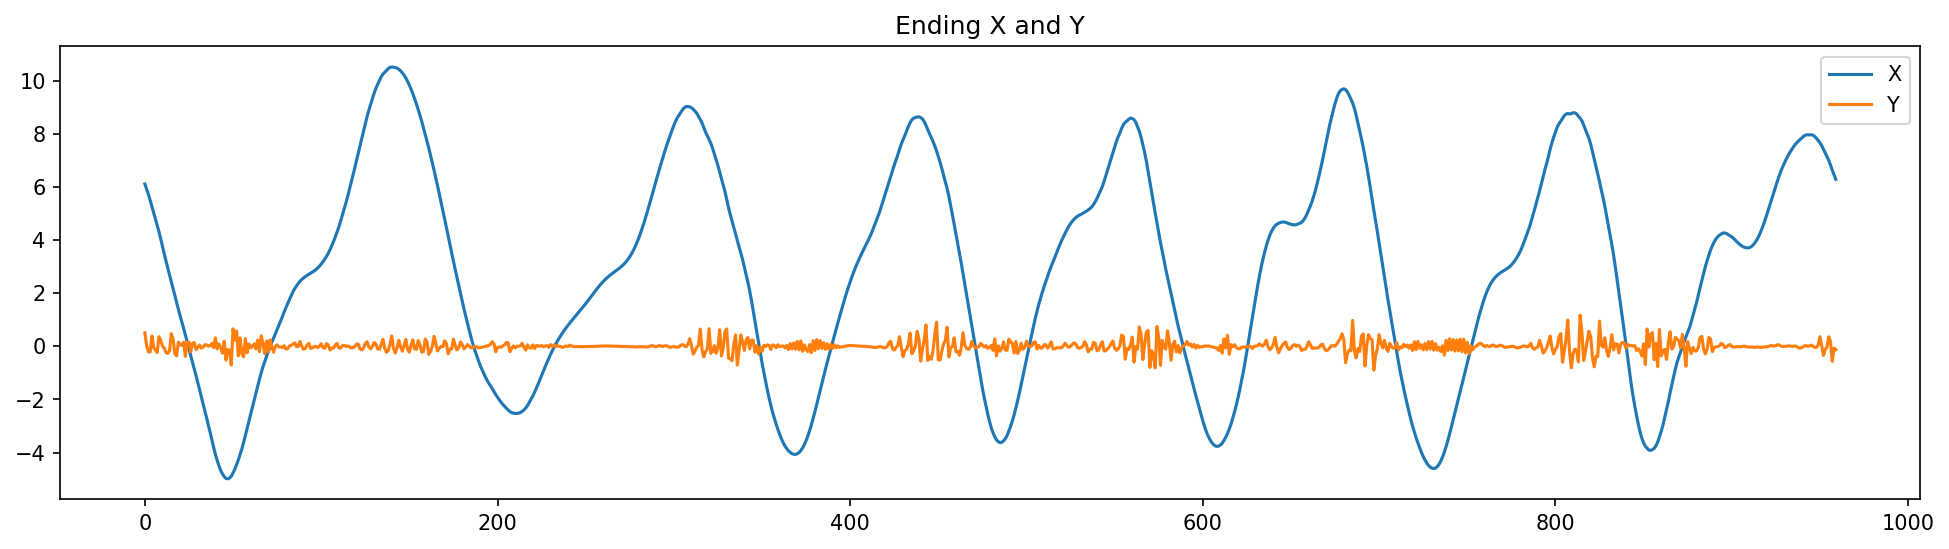

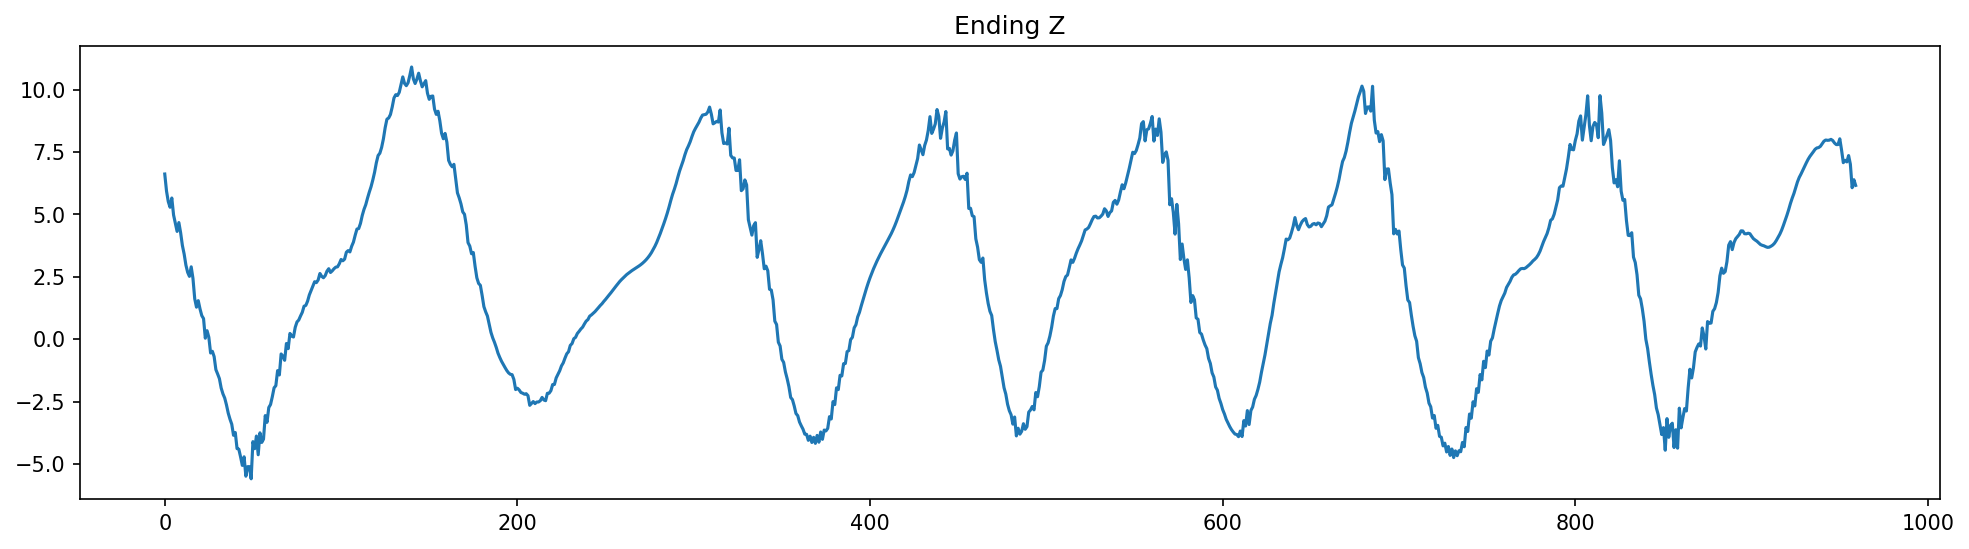

In [523]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

F is 15.0
b is 10.0
c is 2.5
Lx is 0.1
Ly is 4.0
Z std is 4.709451998926505
X std is 4.69860407816862
Y std is 0.1749279706368202
abs(Z) mean is 4.6040777788771345
abs(X) mean is 4.59978071506875
abs(Y) mean is 0.10359547325433105


Text(0.5, 1.0, 'Ending Z')

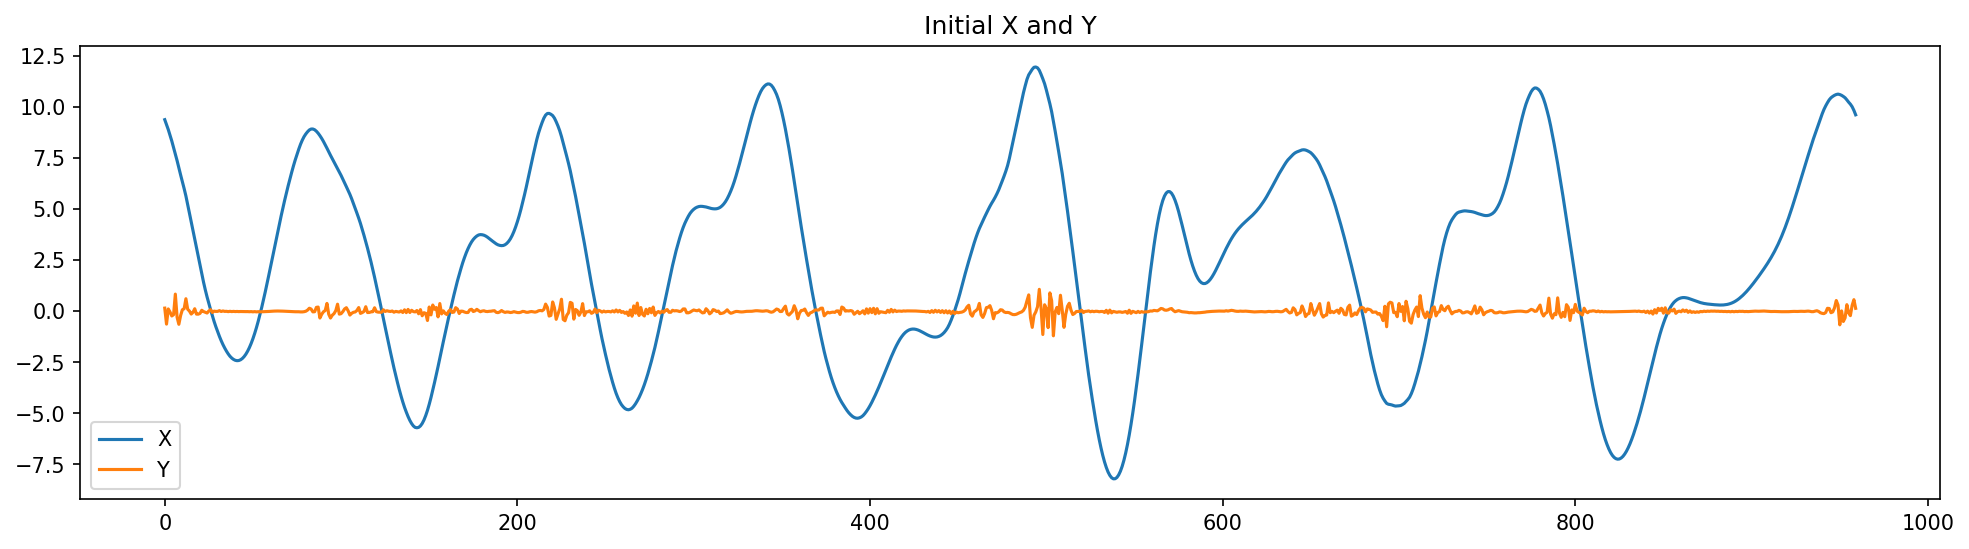

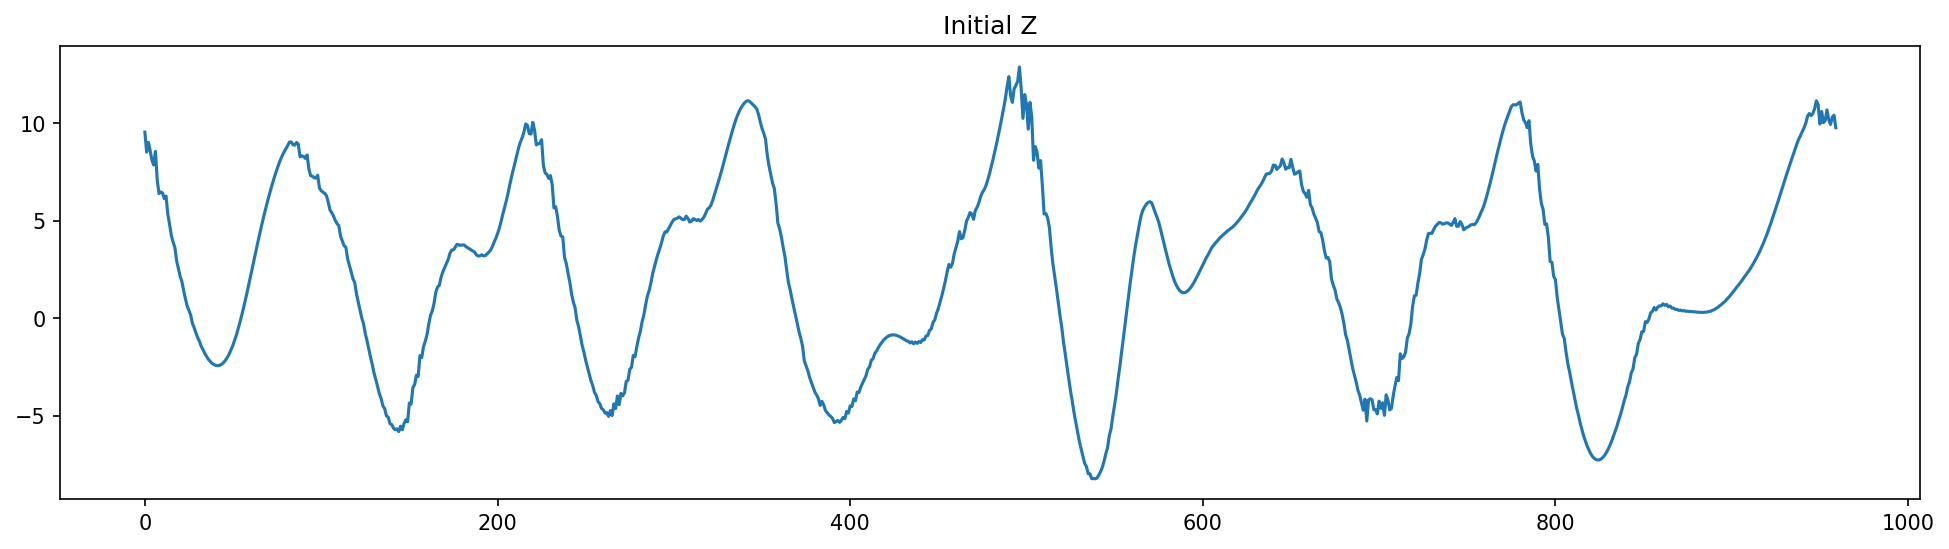

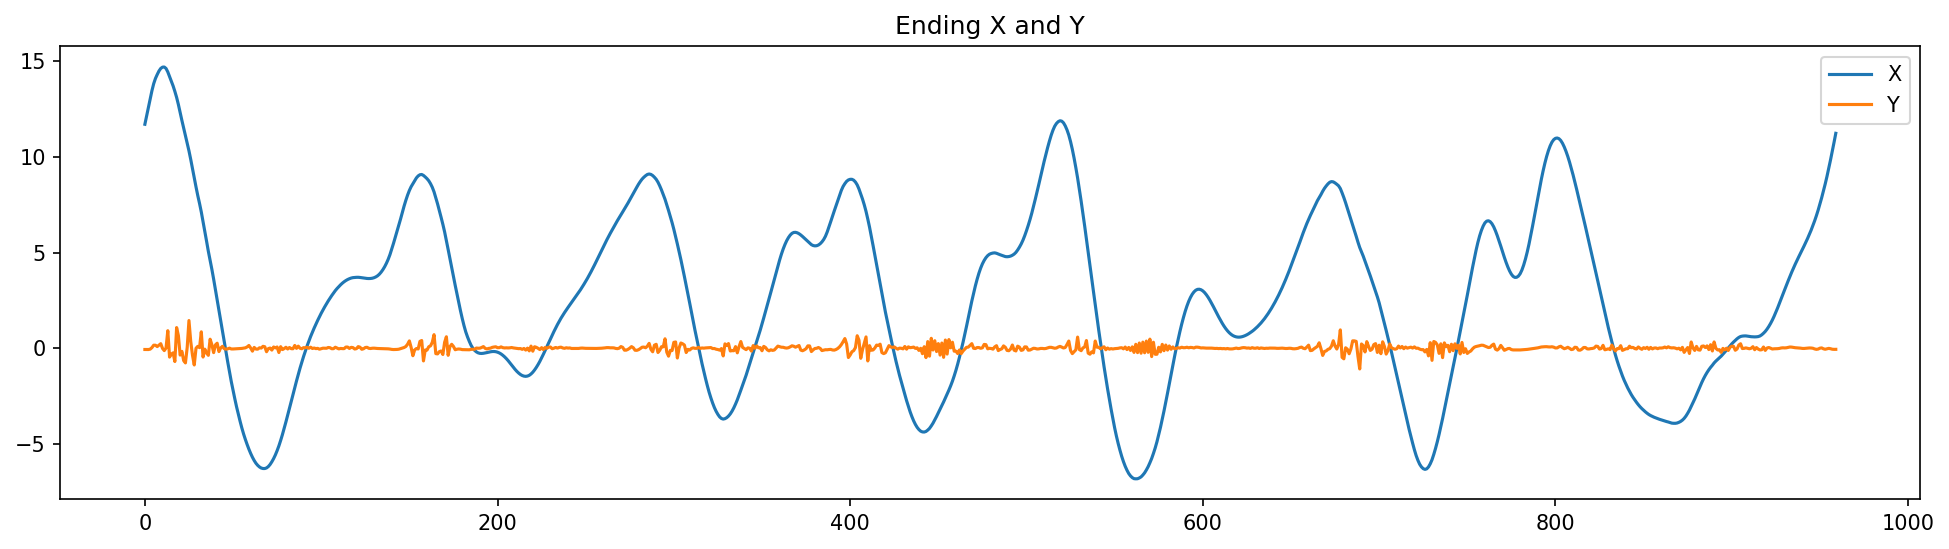

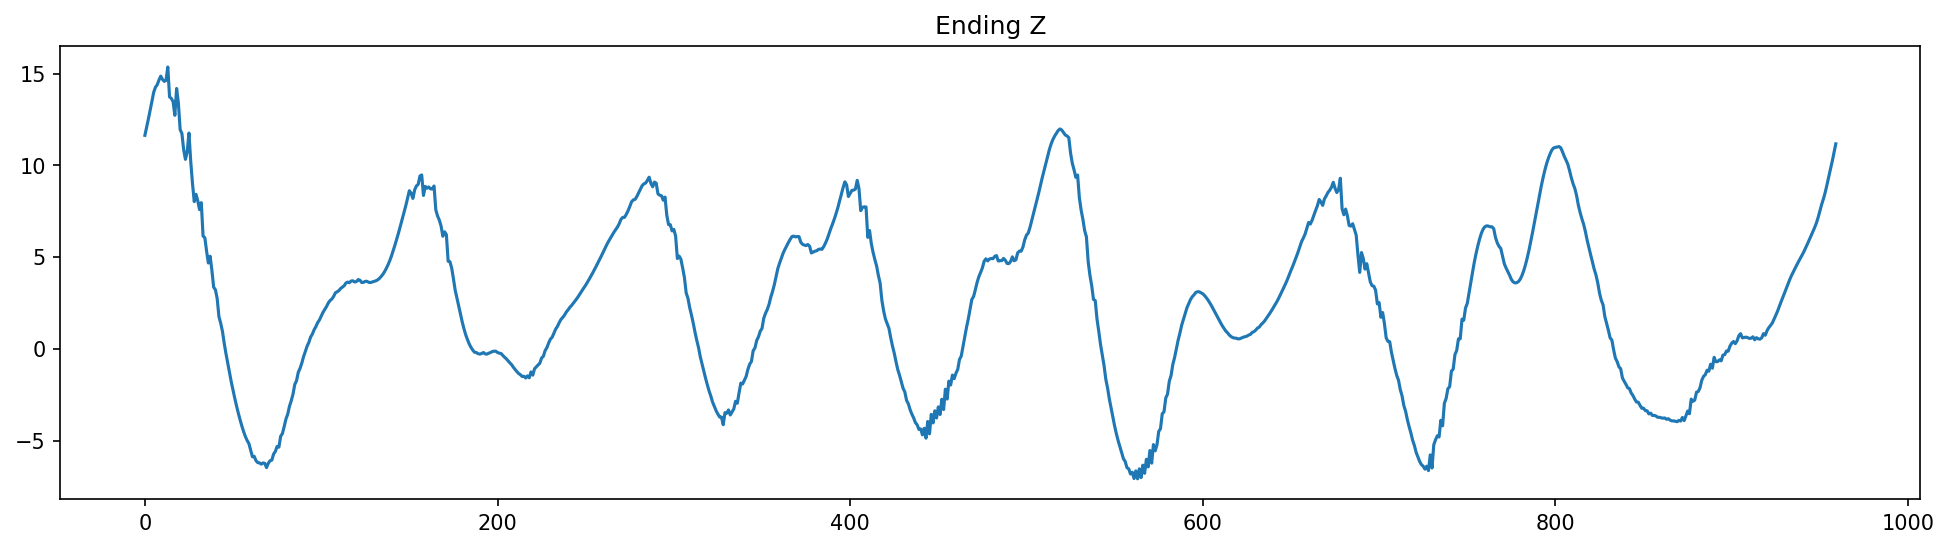

In [518]:
print(f'F is {F}')
print(f'b is {b}')
print(f'c is {c}')
print(f'Lx is {1/b}')
print(f'Ly is {b/c}')
print(f'Z std is {np.std(Z_GT)}')
print(f'X std is {np.std(X_GT)}')
print(f'Y std is {np.std(Y_GT)}')
print(f'abs(Z) mean is {np.mean(np.abs(Z_GT))}')
print(f'abs(X) mean is {np.mean(np.abs(X_GT))}')
print(f'abs(Y) mean is {np.mean(np.abs(Y_GT))}')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, 0])
plt.plot(Y_GT[:, 0])
plt.legend(['X', 'Y'])
plt.title('Initial X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, 0])
plt.title('Initial Z')

figsize = plt.figaspect(1/4)
plt.figure(figsize=figsize, dpi=150)
plt.plot(X_GT[:, -1])
plt.plot(Y_GT[:, -1])
plt.legend(['X', 'Y'])
plt.title('Ending X and Y')

plt.figure(figsize=figsize, dpi=150)
plt.plot(Z_GT[:, -1])
plt.title('Ending Z')

In [569]:
Pert_var = 1e-10

# Error in X only
rho0 = 0.15
[Pert_cor] = covariance.generate_circulant(
    N_Z, dx=1/N_Z, rho0=rho0,
    correlation_fun=covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
Pert = Pert_var * Pert_cor
Zpert = np.random.multivariate_normal(Z_GT[:, 0], Pert, N_eZ).T

# # Error in Y only
# Pert = Pert_var * np.eye(N_Z)
# Zpert = np.random.multivariate_normal(Z_GT[:, 0], Pert, N_eZ).T
# Xpert = utilities.window_sum_Z(Zpert, I=I, alpha=alpha, beta=beta)
# Ypert = Zpert - Xpert
# Zpert = X_GT[:, 0][:, None] + Ypert

In [570]:
Zpert_ts = utilities.return_LM3_ens_data(Zpert, dt=dt_rk, T=T_gt, dt_obs=dt_obs)

Return all


In [571]:
Xpert_ts = Zpert_ts * np.nan
for count in range(Zpert_ts.shape[-1]):
    Xpert_ts[:, :, count] = utilities.window_sum_Z(
        Zpert_ts[:, :, count], I=I, alpha=alpha, beta=beta)
Ypert_ts = Zpert_ts - Xpert_ts

In [572]:
Z_error = Zpert_ts - Z_GT[:, None, :]
X_error = Xpert_ts - X_GT[:, None, :]
Y_error = Ypert_ts - Y_GT[:, None, :]

In [573]:
Z_rmse = np.sqrt((Z_error**2).mean(axis=0))
Z_ave_rmse = Z_rmse.mean(axis=0)

X_rmse = np.sqrt((X_error**2).mean(axis=0))
X_ave_rmse = X_rmse.mean(axis=0)

Y_rmse = np.sqrt((Y_error**2).mean(axis=0))
Y_ave_rmse = Y_rmse.mean(axis=0)

In [574]:
# error only in X

Text(0.5, 1.0, 'RMSE in Y')

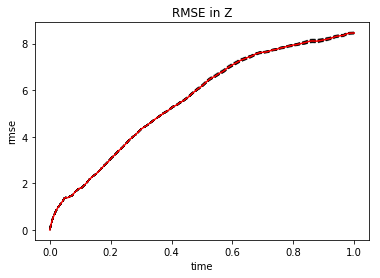

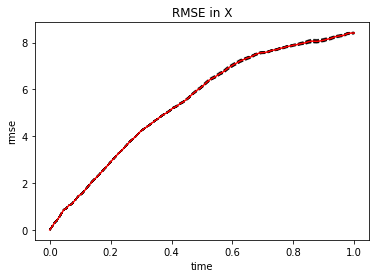

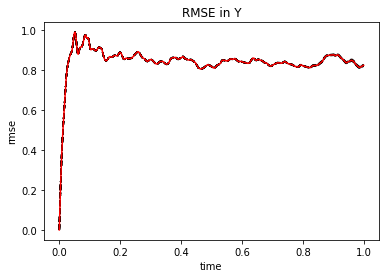

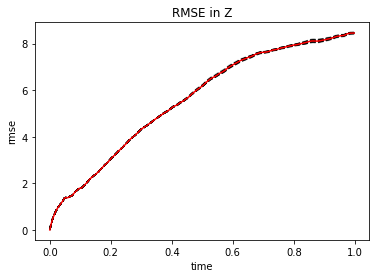

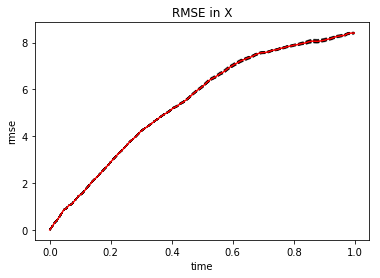

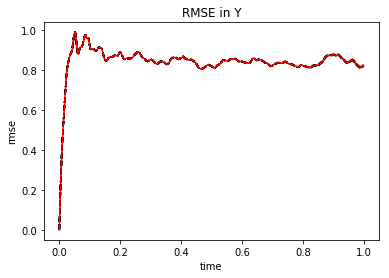

In [575]:
plt.figure()
plt.plot(t_gt, Z_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, Z_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

plt.figure()
plt.plot(t_gt, X_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, X_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

plt.figure()
plt.plot(t_gt, Y_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, Y_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], X_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Y_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

Text(0.5, 1.0, 'RMSE in Y')

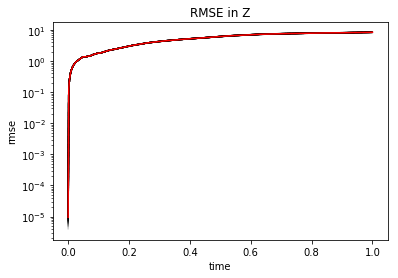

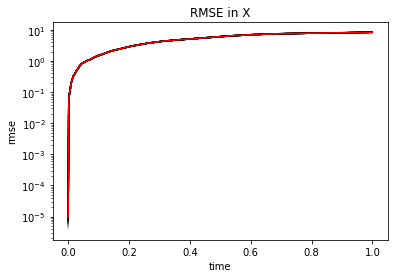

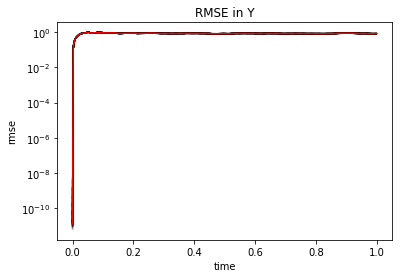

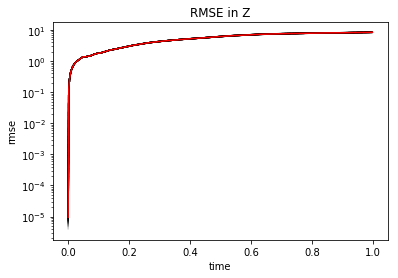

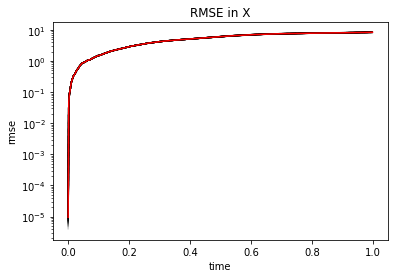

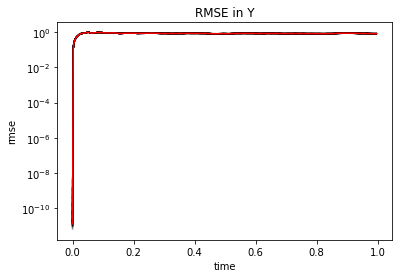

In [576]:
plt.figure()
plt.semilogy(t_gt, Z_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, Z_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

plt.figure()
plt.semilogy(t_gt, X_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, X_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

plt.figure()
plt.semilogy(t_gt, Y_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, Y_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], X_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Y_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

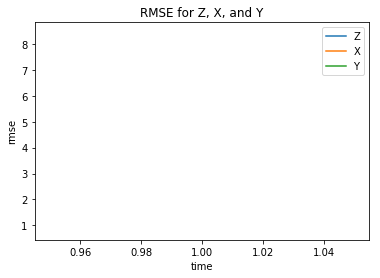

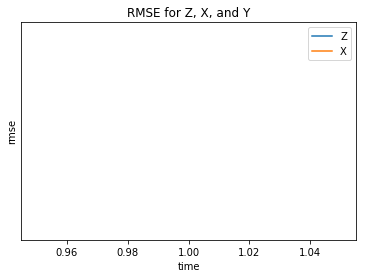

In [577]:
time0 = 10
time1 = 100

start = np.abs(t_gt - time0).argmin()
stop = np.abs(t_gt - time1).argmin()
slice_plot = slice(start, stop + 1)


plt.figure()
plt.plot(t_gt[slice_plot], Z_ave_rmse[slice_plot])
plt.plot(t_gt[slice_plot], X_ave_rmse[slice_plot])
plt.plot(t_gt[slice_plot], Y_ave_rmse[slice_plot])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])


plt.figure()
plt.semilogy(t_gt[slice_plot], Z_ave_rmse[slice_plot])
plt.semilogy(t_gt[slice_plot], X_ave_rmse[slice_plot])
# plt.semilogy(t_gt[slice_plot], Y_ave_rmse[slice_plot])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

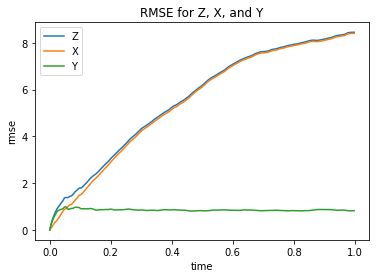

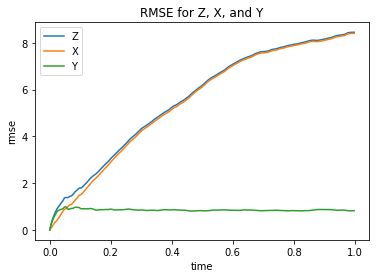

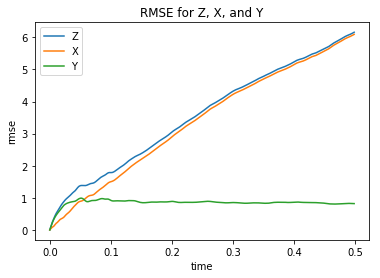

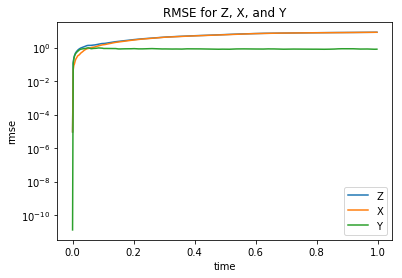

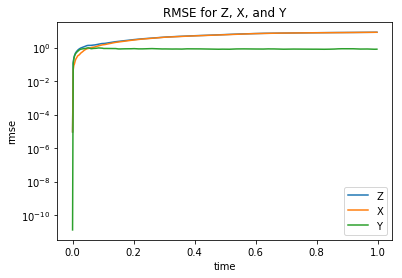

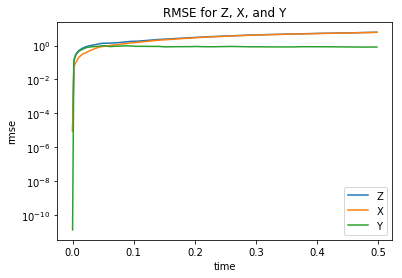

In [578]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

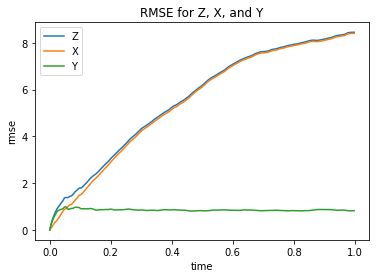

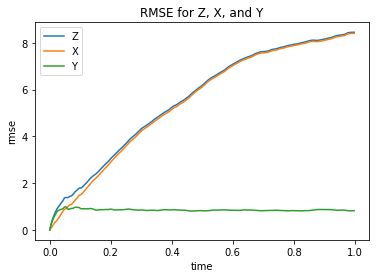

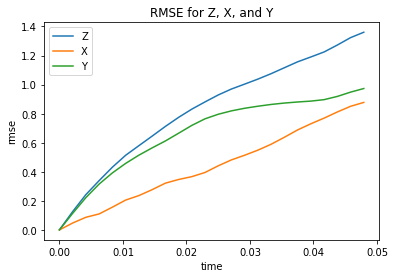

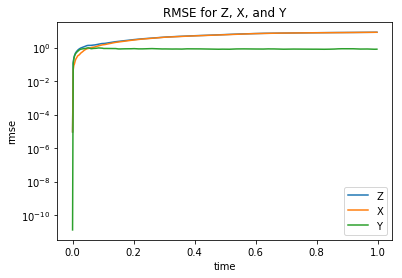

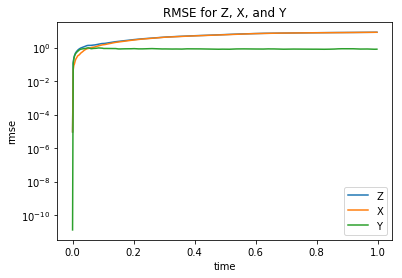

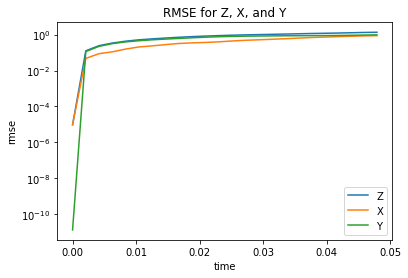

In [579]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.05
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.05
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

In [580]:
Pert_var = 1e-10

# # Error in X only
# rho0 = 0.15
# [Pert_cor] = covariance.generate_circulant(
#     N_Z, dx=1/N_Z, rho0=rho0,
#     correlation_fun=covariance.fft_sqd_exp_1d,
#     return_Corr=True, return_eig=False)
# Pert = Pert_var * Pert_cor
# Zpert = np.random.multivariate_normal(Z_GT[:, 0], Pert, N_eZ).T

# Error in Y only
Pert = Pert_var * np.eye(N_Z)
Zpert = np.random.multivariate_normal(Z_GT[:, 0], Pert, N_eZ).T
Xpert = utilities.window_sum_Z(Zpert, I=I, alpha=alpha, beta=beta)
Ypert = Zpert - Xpert
Zpert = X_GT[:, 0][:, None] + Ypert

In [581]:
Zpert_ts = utilities.return_LM3_ens_data(Zpert, dt=dt_rk, T=T_gt, dt_obs=dt_obs)

Return all


In [582]:
Xpert_ts = Zpert_ts * np.nan
for count in range(Zpert_ts.shape[-1]):
    Xpert_ts[:, :, count] = utilities.window_sum_Z(
        Zpert_ts[:, :, count], I=I, alpha=alpha, beta=beta)
Ypert_ts = Zpert_ts - Xpert_ts

In [583]:
Z_error = Zpert_ts - Z_GT[:, None, :]
X_error = Xpert_ts - X_GT[:, None, :]
Y_error = Ypert_ts - Y_GT[:, None, :]

In [584]:
Z_rmse = np.sqrt((Z_error**2).mean(axis=0))
Z_ave_rmse = Z_rmse.mean(axis=0)

X_rmse = np.sqrt((X_error**2).mean(axis=0))
X_ave_rmse = X_rmse.mean(axis=0)

Y_rmse = np.sqrt((Y_error**2).mean(axis=0))
Y_ave_rmse = Y_rmse.mean(axis=0)

In [585]:
# error only in Y

Text(0.5, 1.0, 'RMSE in Y')

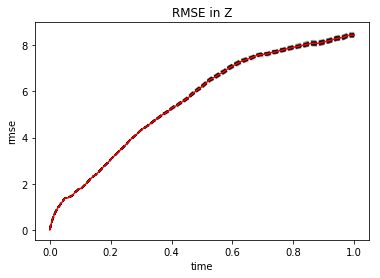

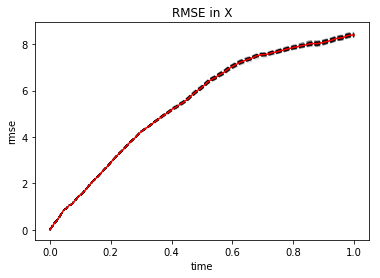

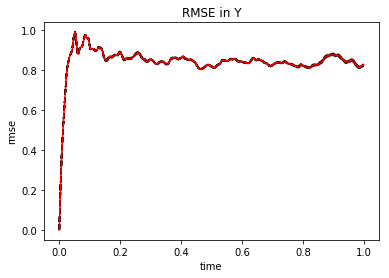

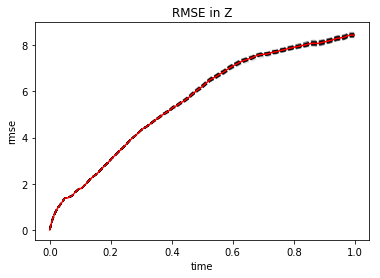

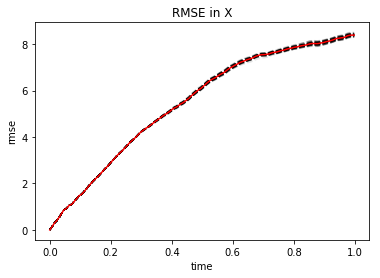

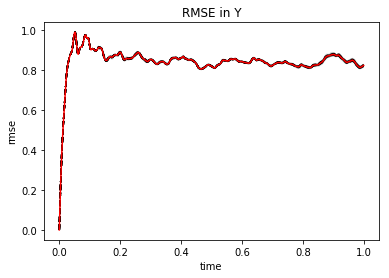

In [586]:
plt.figure()
plt.plot(t_gt, Z_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, Z_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

plt.figure()
plt.plot(t_gt, X_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, X_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

plt.figure()
plt.plot(t_gt, Y_rmse.T, 'k--', alpha=0.1)
plt.plot(t_gt, Y_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], X_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Y_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

Text(0.5, 1.0, 'RMSE in Y')

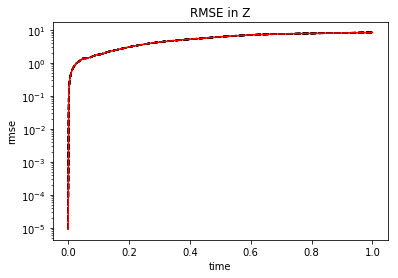

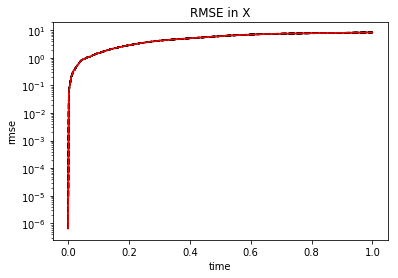

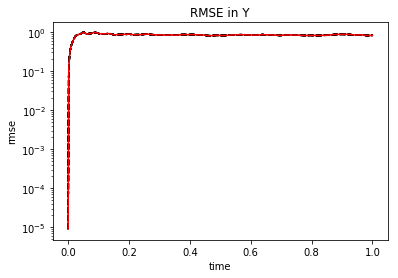

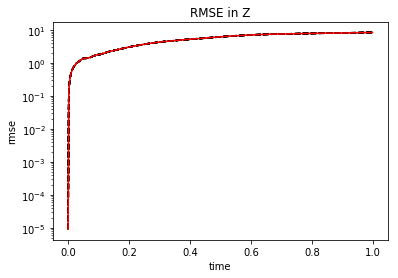

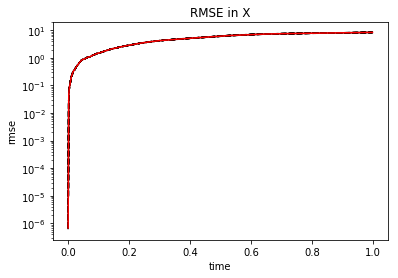

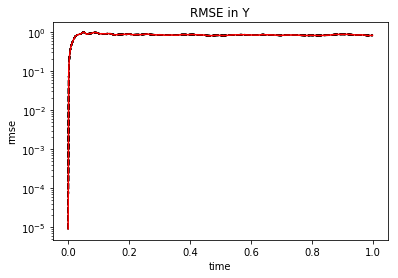

In [587]:
plt.figure()
plt.semilogy(t_gt, Z_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, Z_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

plt.figure()
plt.semilogy(t_gt, X_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, X_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

plt.figure()
plt.semilogy(t_gt, Y_rmse.T, 'k--', alpha=0.1)
plt.semilogy(t_gt, Y_ave_rmse, 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], X_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Y_rmse[:, :this_index].T, 'k--', alpha=0.1)
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index], 'r')
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE in Y')

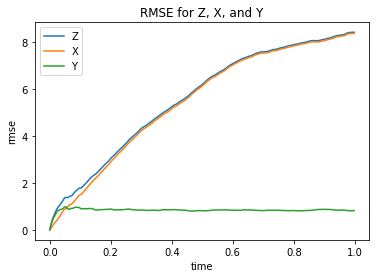

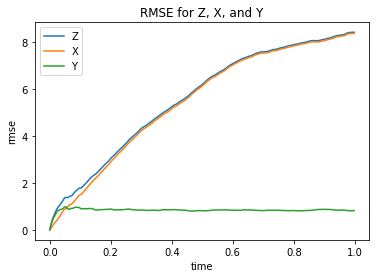

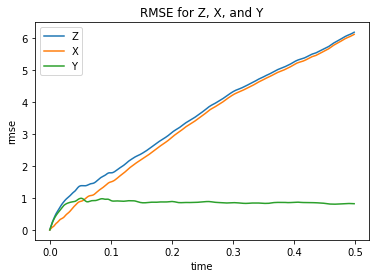

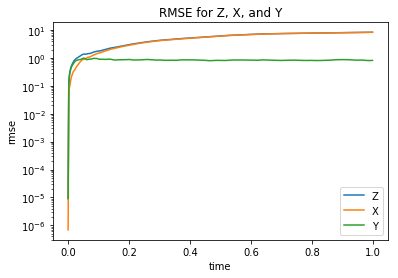

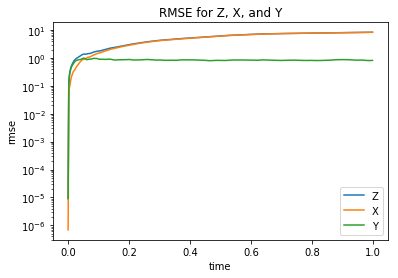

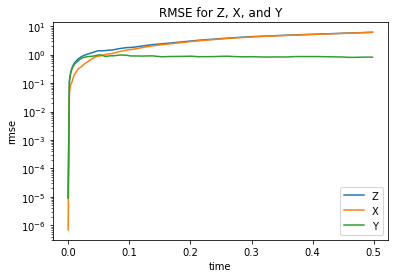

In [588]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

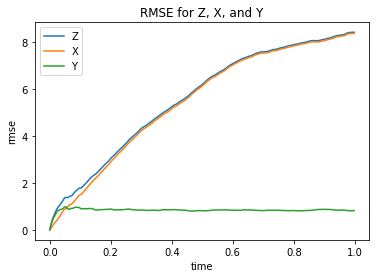

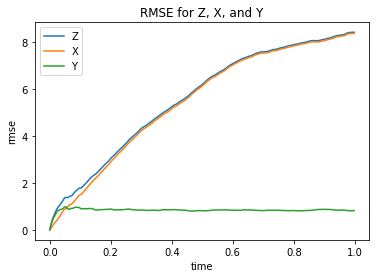

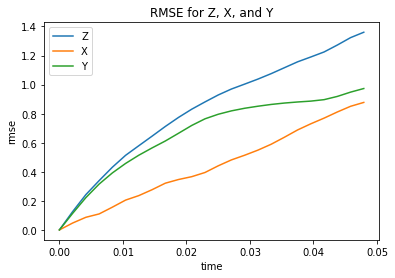

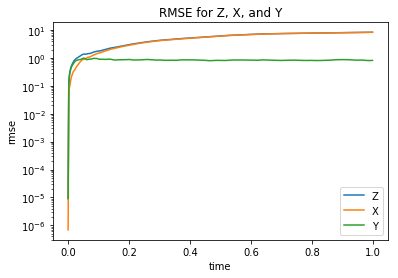

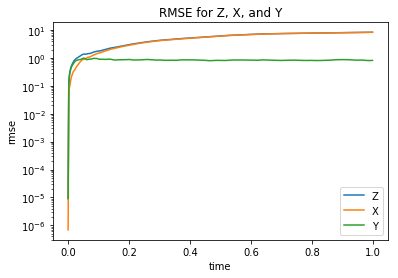

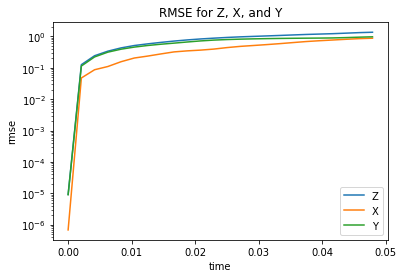

In [589]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.05
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], X_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.05
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], X_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])